In [103]:
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.stats import norm
import random



import matplotlib as mpl
from matplotlib import cm
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from astroML.datasets import fetch_rrlyrae_combined
from astroML.classification import GMMBayes
from astroML.utils import split_samples
from astroML.datasets import fetch_imaging_sample


import time

from cesium import featurize


In [2]:
# Required Fucntions
def plot_timeseries(df: pd.DataFrame, indx=0 ) -> None:
    '''Plot the generated time series data.
        Args:
            df: Pandas DataFrame with the generated data
            indx: index of the time series to plot
        '''
    df[f'y{indx}' ].plot(style='o')  

    plt.show()


# Section 1: Gussian Mixture Model

### Assignment:

 - develop 3 approaches for classifying time series
 - the initial approach should extract features from a time series (e.g. using cesium-ml) and apply a GMM classifier (you will need to define how you will classify a continuous function such as period). 
 - The classifier should be robust to changes in the phase of the time series

### Gaussian Mixture Model Bayes

In GMM Bayes, we model each class as having a Gaussian Mixture Model distribution with $N$ components:
$$p(x|y_k) = \sum_{l=1}^N \frac{w_{k,l}}{\sqrt{\det 2\pi \Sigma_{k,l}}} \exp\left( -\frac{1}{2} (x - \mu_{k,l})^T \Sigma_{k,l}^{-1} (x - \mu_{k,l})\right)$$
with $\sum_{l=1}^N w_{k,l} = 1$ to make sure the mixture model is normalized.

<!-- In the case of $N=1$, this is Gaussian Naive Bayes except the covariance matrix can have off-diagonal elements, and is also called Quadratic Discriminant Analysis because the decision boundary is quadratic in $x$.m -->

where:
- $w_{k,l}$ is the weight for k-th component

In this notebook, we apply gussian mixture model to timeseries data with a single, multiple and sampled multiple frequency at different phases and the plasticc dataset with stellar parameters. We use a

Goal of the project


Why and Background?
- The timeseries features datasets and plasticc parameters have a complex function and are difficult to get a analytic solution for a maximum likihood estimators(MLE). 
- Gussian Mixture Models is an unsupervised learning method because the model learns the subpopulation automatically without the requiring to know which subpopulation each data point belongs to.
- It uses expectation-maximization (EM) algorithm which a is an iterative way to approximate the maximum likelihood function. The more complex EM algorithm can find model parameters even if you have missing data.
- a component refers to one of the individual Gaussian distributions that make up the entire mixture model. Each component represents a cluster within the data, characterized by its own mean vector, covariance matrix, and weight.
- Gaussian Mixture Models (GMMs) are probabilistic models that assume all the data points are generated from a mixture of several Gaussian distributions with unknown parameters. Each Gaussian distribution represents a cluster within the data.

<!-- - It works by choosing random values for the missing data points and using those guesses to estimate a second set of data. The new values are used to create a better guess for the first set, and the process continues until the algorithm converges on a fixed point. -->

<!-- probabilistic models that assume all the data points are generated from a mixture of several Gaussian distributions with unknown parameters. Each Gaussian distribution represents a cluster within the data. -->

## Steps for classifying timeseries and plasticc datasets
 1. Read in pickle of the lightcurves to a pandas dataframe 
 2. Use cesium to generate feature of each light curve
- 2.1 X - ceasium features
- 2.2 y - periods (generated from cesium)
 3. Data Split between train, valid and test sets
 4. Use GMMBayes function to classifiy the lightcurves and predicts the period
 5. Calculate the recall and precision 
 6. Plot confunsion matrix for the dataset


## Part 1: Timesseries with single frequency (at different phases)

#### 1a: A single cell that runs the GMM for the single frequency light curve see 1b. for code break down, visualization of cecium features and the end results is the same
-  Cesuim was used to generate the features but takes a significanly long time to compute them. We thus run cesium once then save it to a csv file for us to read in later. To run in code uncomment lines 26-41 and 63-65 

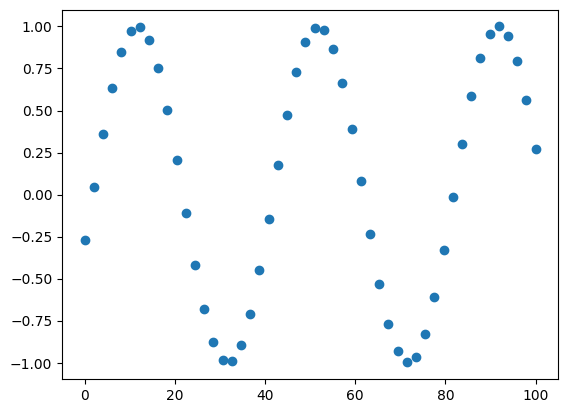

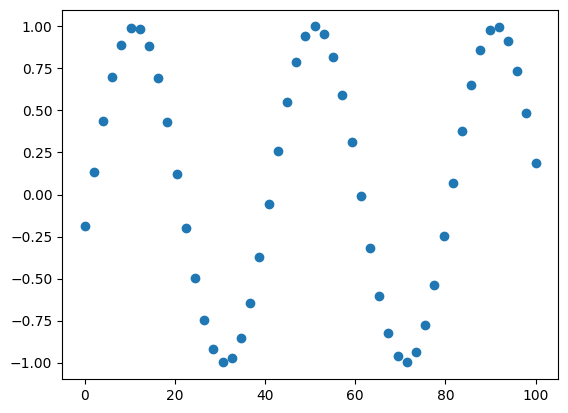

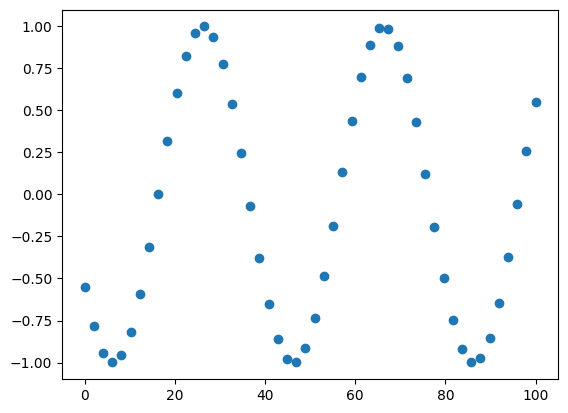

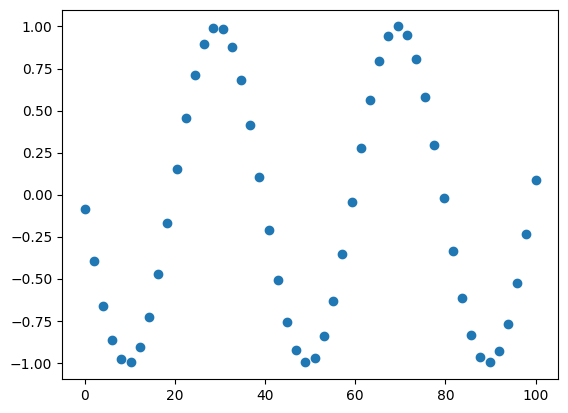

/var/folders/41/1_71sw_13ql14yq5j387scf80000gn/T/ipykernel_43948/3142242472.py:44: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_single = pd.read_csv('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/single_freq_cesium_features.csv')


y: [0. 0. 0. ... 0. 0. 0.]
X: (100000, 12), y: (100000,)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Stellar Type Recall 1.000
Stellar Type Precision 1.000


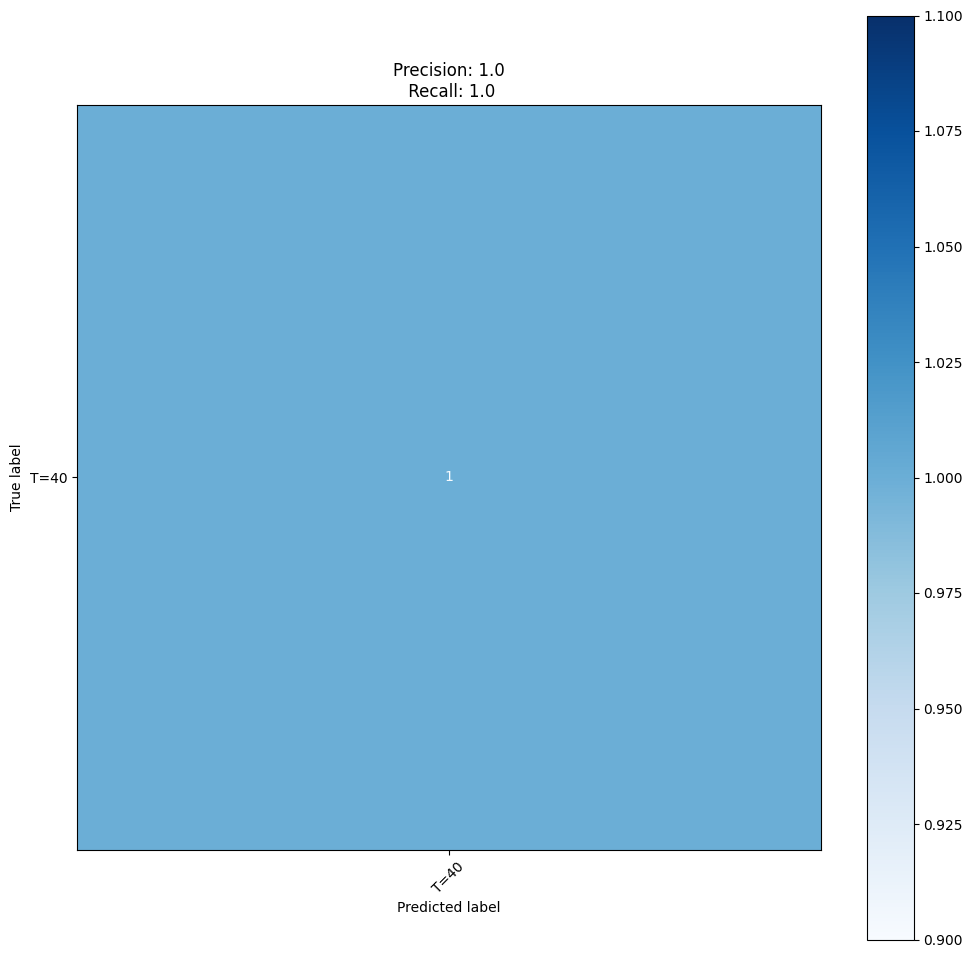

In [41]:
# periods = multifreq_fset_cesium['period_fast'].values[0][:]
# %%time
# Read in timesseries data
df_single = pd.read_feather('/Users/mmckay/Desktop/astr598_spr24_classification_repo/data/timeseries_single_frequency.feather')
plot_timeseries(df_single, indx=34)
plot_timeseries(df_single, indx=82)
plot_timeseries(df_single, indx=11)
plot_timeseries(df_single, indx=95697)

# Set feature list you want from cesium 
features_to_use = [
    "amplitude",
    "percent_beyond_1_std",
    "maximum",
    "max_slope",
    "median",
    "median_absolute_deviation",
    "percent_close_to_median",
    "minimum",
    "skew",
    "std",
    "period_fast",
    "weighted_average",
]

# Run Cesium on the single frequency time series data
# # Create a list of cesium features including periods
# cesium_results=[]
# periods=[]

# for i in range(100000):
#     fset_cesium = featurize.featurize_time_series(
#         times=df_single[f'y'+str(i)].index[np.isfinite(df_single[f'y'+str(i)].values)],
#         values=df_single[f'y'+str(i)].values[np.isfinite(df_single[f'y'+str(i)].values)],
#         errors=None,
#         features_to_use=features_to_use,
#     )
    
#     cesium_results.append(fset_cesium)
#     periods.append(fset_cesium.period_fast.values[0][0])
# cesium_results[0]

# Read in saved cesium features
df_single = pd.read_csv('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/single_freq_cesium_features.csv')
periods = df_single['period_fast'].values[1:]
# periods = np.array(pd.read_pickle('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/periods_multiple_freq.pkl'))


# Bin the periods into increments of 5
classes=np.zeros(len(periods))
for i in range(len(periods)):
    classes[i]=int((np.array(periods[i])-40)/5)


y = classes
print(f'y: {y}')
X = df_single.drop(columns=['period_fast']).values[1:]
print(f'X: {X.shape}, y: {y.shape}')

# # Set features and truth labels - X, y for appending values
# X=np.zeros((len(periods), len(features_to_use)-1))


# for i in range(len(periods)):
#     X[i]= cesium_results[i]['amplitude'].values[0][0], cesium_results[i]['percent_beyond_1_std'].values[0][0], cesium_results[i]['maximum'].values[0][0], cesium_results[i]['max_slope'].values[0][0], cesium_results[i]['median'].values[0][0], cesium_results[i]['median_absolute_deviation'].values[0][0], cesium_results[i]['percent_close_to_median'].values[0][0], cesium_results[i]['minimum'].values[0][0], cesium_results[i]['skew'].values[0][0], cesium_results[i]['std'].values[0][0], cesium_results[i]['weighted_average'].values[0][0]   

# y = classes
# print(f'y: {y}')

# Data Split
(X_train, X_valid, X_test), (y_train, y_valid, y_test) = split_samples(X, y, [0.8, 0.1, 0.1], random_state=0)

# GMM Classifier
gmmb = GMMBayes(n_components=4, random_state=0)
gmmb.fit(X_train, y_train)
y_pred = gmmb.predict(X_valid)

# labels = ['Period_U40', 'Period_40_45', 'Period_45_50', 'Period_50_55', 'Period_55_60', 'Period_60_65', 'Period_65_70', 
#           'Period_70_75', 'Period_75_80', 'Period_80_85', 'Period_85_90', 'Period_90_95', 'Period_95_100']
labels = ['T=40']
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot()
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred, display_labels=labels, cmap='Blues', ax=ax, normalize='true', xticks_rotation=45)
print('Stellar Type Recall %0.3f' % recall_score(y_valid, y_pred, average='weighted'))
print('Stellar Type Precision %0.3f' % precision_score(y_valid, y_pred, average='weighted'))
plt.title(f'Precision: {np.round(precision_score(y_valid, y_pred, average="weighted"), 3)}\n Recall: {np.round(recall_score(y_valid, y_pred, average="weighted"), 3)}')
plt.show()

<Axes: ylabel='Count'>

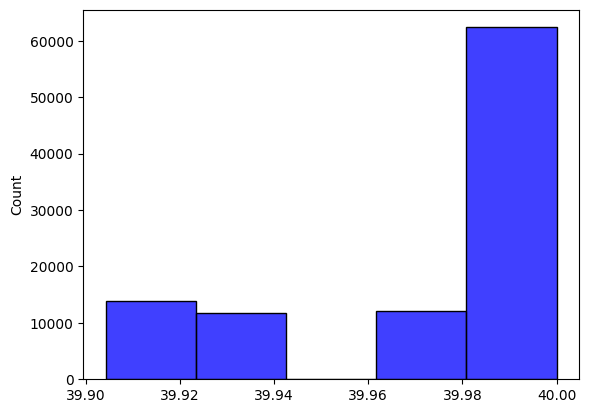

In [40]:
sns.histplot(periods, color='blue', label='True', bins=5)
# periods.min()

### 1b. The cell above but broken into multiple cells

### 1. Read in periods and visualize the results

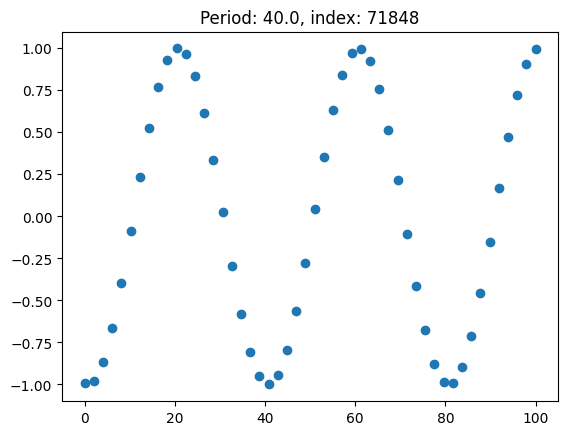

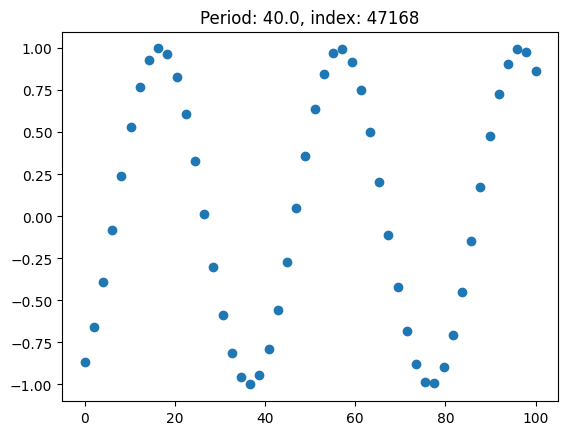

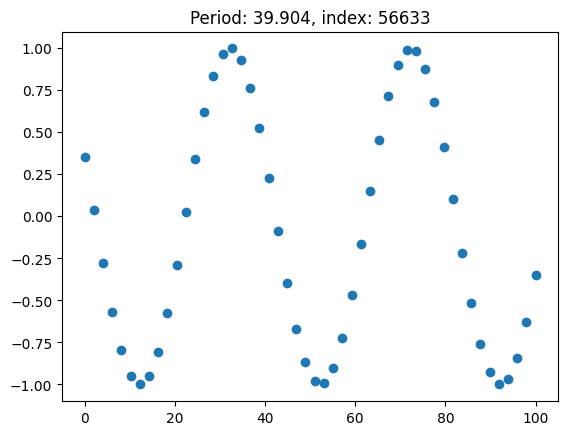

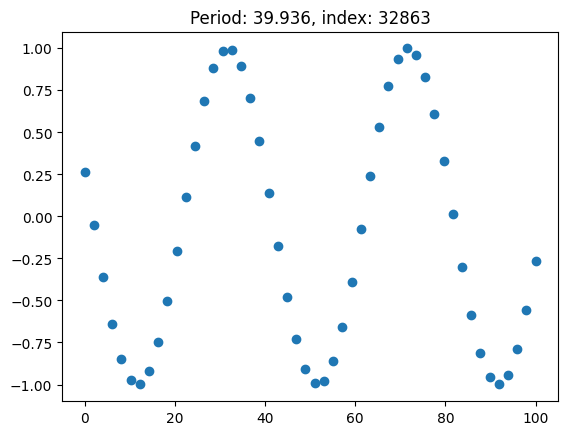

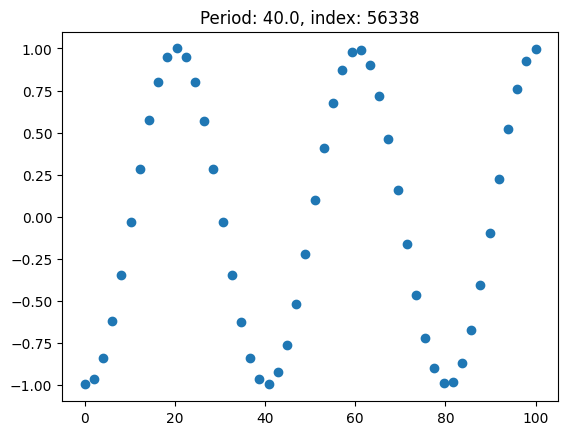

In [46]:
# Read in timesseries data
df_single = pd.read_feather('/Users/mmckay/Desktop/astr598_spr24_classification_repo/data/timeseries_single_frequency.feather')

for value in random.sample(range(1, 100001), 5):
    plt.title(f'Period: {np.round(periods[value], 3)}, index: {value}')
    plot_timeseries(df_single, indx=value)

### 2. Extract features using cesium
- takes about 20-30 mins to complete!!!

In [5]:
# # Set feature list you want from cesium 
# features_to_use = [
#     "amplitude",
#     "percent_beyond_1_std",
#     "maximum",
#     "max_slope",
#     "median",
#     "median_absolute_deviation",
#     "percent_close_to_median",
#     "minimum",
#     "skew",
#     "std",
#     "period_fast",
#     "weighted_average",
# ]


# # Create a list of cesium features including periods
# cesium_results=[]
# periods=[]

# for i in range(100000):
#     fset_cesium = featurize.featurize_time_series(
#         times=df_single[f'y'+str(i)].index[np.isfinite(df_single[f'y'+str(i)].values)],
#         values=df_single[f'y'+str(i)].values[np.isfinite(df_single[f'y'+str(i)].values)],
#         errors=None,
#         features_to_use=features_to_use,
#     )
    
#     cesium_results.append(fset_cesium)
#     periods.append(fset_cesium.period_fast.values[0][0])
# cesium_results[0]

# # Set classes and X and y values
# # Bin the periods into increments of 5
# classes=np.zeros(len(periods))
# for i in range(len(periods)):
#     classes[i]=int((np.array(periods[i])-40)/5)
# # periods = np.array(pd.read_pickle('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/periods_multiple_freq.pkl'))


# # Set features and truth labels - X, y for appending values
# X=np.zeros((len(periods), len(features_to_use)-1))
# y = classes
# print(f'y: {y}')



# for i in range(len(periods)):
#     X[i]= cesium_results[i]['amplitude'].values[0][0], cesium_results[i]['percent_beyond_1_std'].values[0][0], cesium_results[i]['maximum'].values[0][0], cesium_results[i]['max_slope'].values[0][0], cesium_results[i]['median'].values[0][0], cesium_results[i]['median_absolute_deviation'].values[0][0], cesium_results[i]['percent_close_to_median'].values[0][0], cesium_results[i]['minimum'].values[0][0], cesium_results[i]['skew'].values[0][0], cesium_results[i]['std'].values[0][0], cesium_results[i]['weighted_average'].values[0][0]   

# y = classes
# print(f'y: {y.shape}, X: {X.shape}')




# # Save the featurized data !Takes 4 minutes to run
# fset_cesium.to_csv('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/single_freq_cesium_features.csv')
# fset_cesium.to_feather('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/single_freq_cesium_features.feather')

- Read in saved dataframe

In [50]:
# Read in saved cesium features
df_single = pd.read_csv('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/single_freq_cesium_features.csv')
periods = df_single['period_fast'].values[1:]


/var/folders/41/1_71sw_13ql14yq5j387scf80000gn/T/ipykernel_43948/3579601976.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_single = pd.read_csv('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/single_freq_cesium_features.csv')


In [51]:
df_single.columns

Index(['feature', 'amplitude', 'percent_beyond_1_std', 'maximum', 'max_slope',
       'median', 'median_absolute_deviation', 'percent_close_to_median',
       'minimum', 'skew', 'std', 'period_fast', 'weighted_average'],
      dtype='object')

### Visualize Cesium features for timeseries

<Axes: xlabel='weighted_average', ylabel='Count'>

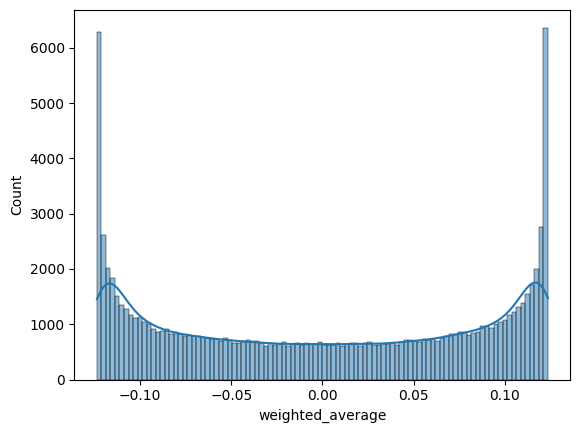

In [52]:
sns.histplot(df_single['weighted_average'], bins=100, kde=True)

<Figure size 2000x2000 with 0 Axes>

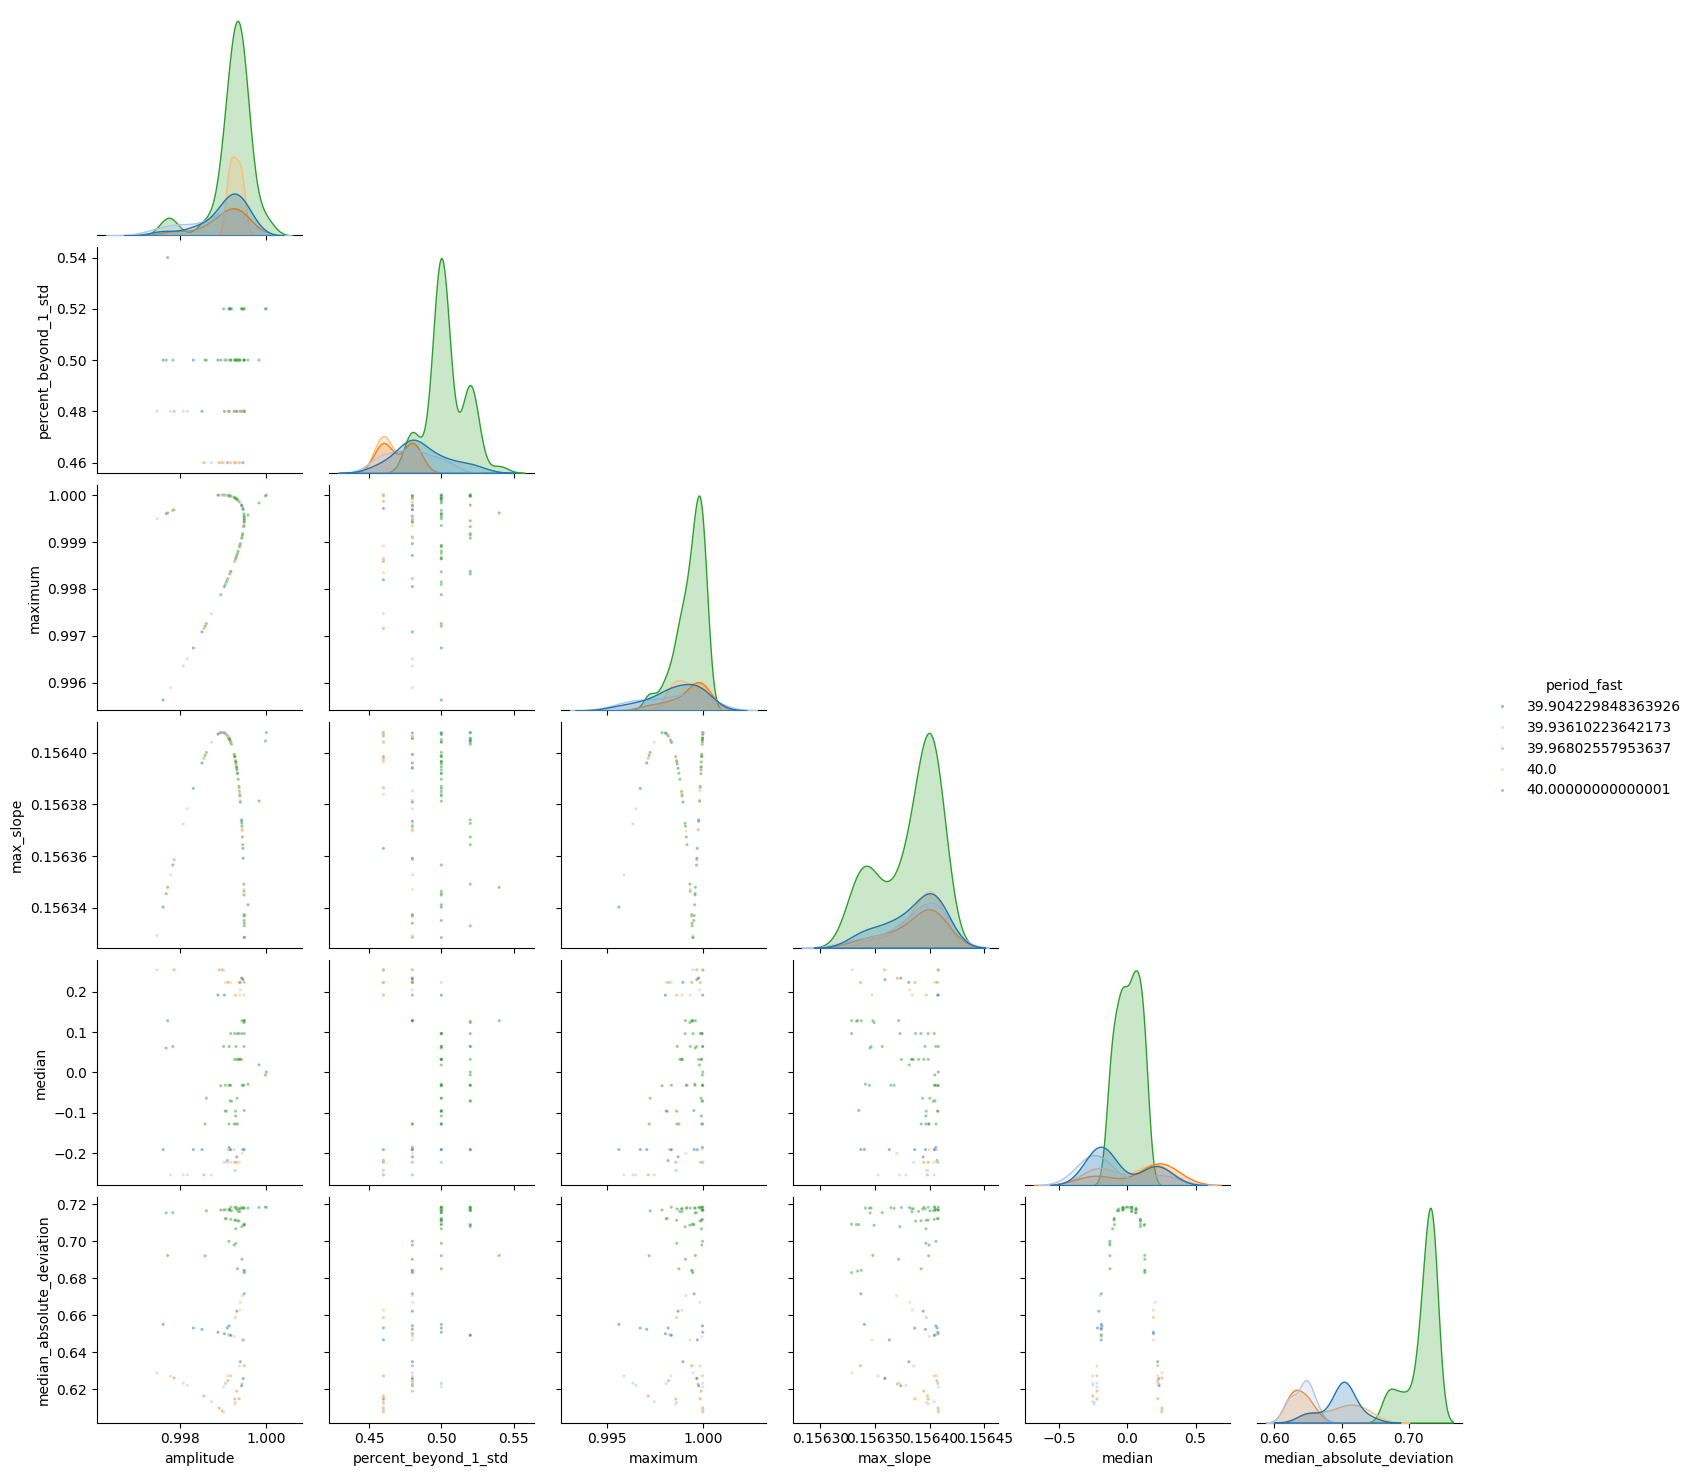

In [62]:
# Assuming your dataframe is named 'df'
sampled_df_single = df_single.sample(n=100, replace=False)

cols = ['amplitude', 'percent_beyond_1_std', 'maximum', 'max_slope',
       'median', 'median_absolute_deviation']
fig = plt.figure(figsize=(20,20))
sns.pairplot(sampled_df_single, 
            x_vars=cols,
            y_vars=cols,
            hue='period_fast', palette='tab20',
            corner=True,
            plot_kws={'alpha':0.5, 's':5})


### 3. Formating feature dataframe for GMMBayes classifyer
- Define classes (Bin the periods into increments of 5)
- setting X and y


In [64]:
# Bin the periods into increments of 5
classes=np.zeros(len(periods))
for i in range(len(periods)):
    classes[i]=int((np.array(periods[i])-40)/5)
y = classes

# Select all values except the periods
X = df_single.drop(columns=['period_fast']).values[1:]
print(f'X: {X.shape}, \ny: {y.shape}')

X: (100000, 12), 
y: (100000,)


### 4. Data Split

In [65]:
# Data Split
(X_train, X_valid, X_test), (y_train, y_valid, y_test) = split_samples(X, y, [0.8, 0.1, 0.1], random_state=0)
print(f'Training set N={len(X_train)}, Shape:{X_train.shape}\nTesting set N={len(X_test)}, Shape:{X_test.shape} \nValidation set N={len(X_valid)}, Shape:{X_valid.shape}\n') 
print(f'Training set N={len(y_train)}, Shape:{y_train.shape}\nTesting set N={len(y_test)}, Shape:{y_test.shape} \nValidation set N={len(y_valid)}, Shape:{y_valid.shape}') 

Training set N=80000, Shape:(80000, 12)
Testing set N=10000, Shape:(10000, 12) 
Validation set N=10000, Shape:(10000, 12)

Training set N=80000, Shape:(80000,)
Testing set N=10000, Shape:(10000,) 
Validation set N=10000, Shape:(10000,)


### 5. Gussian Mixture Model Bayes form astroML package

In [66]:
# GMM Classifier
gmmb = GMMBayes(n_components=4, random_state=0)
gmmb.fit(X_train, y_train)
y_pred = gmmb.predict(X_valid)

# fig = plt.figure(figsize=(2,2))
# ax = fig.add_subplot()
# ConfusionMatrixDisplay.from_predictions(y_valid, y_pred, display_labels=labels, cmap='Blues', ax=ax)
# plt.show()

# # when there are only two classes, scikit-learn will calculate the precision/recall for class=1 only
print('Period=40 Recall %0.3f' % recall_score(y_valid, y_pred, average='weighted'))
print('Period=40 Precision %0.3f' % precision_score(y_valid, y_pred, average='weighted'))

Period=40 Recall 1.000
Period=40 Precision 1.000


#### 5.1 plot of recall and precision as a function of the number of components in the GMM


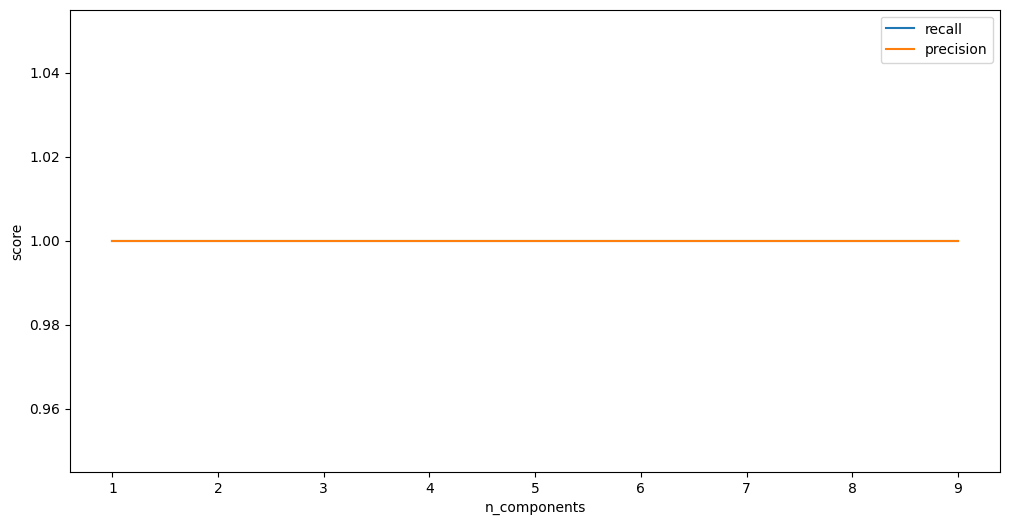

In [67]:
n_components = np.arange(1, 10)
recall = np.zeros(n_components.shape)
precision = np.zeros(n_components.shape)
for i, n in enumerate(n_components):
    gmmb = GMMBayes(n_components=n, random_state=0)
    gmmb.fit(X_train, y_train)
    y_pred = gmmb.predict(X_valid)
    recall[i] = recall_score(y_valid, y_pred, average='weighted')
    precision[i] = precision_score(y_valid, y_pred, average='weighted')

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
ax.plot(n_components, recall, label='recall')
ax.plot(n_components, precision, label='precision')
ax.set_xlabel('n_components')
ax.set_ylabel('score')
ax.legend()
plt.show()

##### The cross-validation shows that the model will preforme well no matter the number of componets since there is only a single class to classify in

### 6. Confusion Matrix

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Period=40 Recall 1.000
Period=40 Precision 1.000


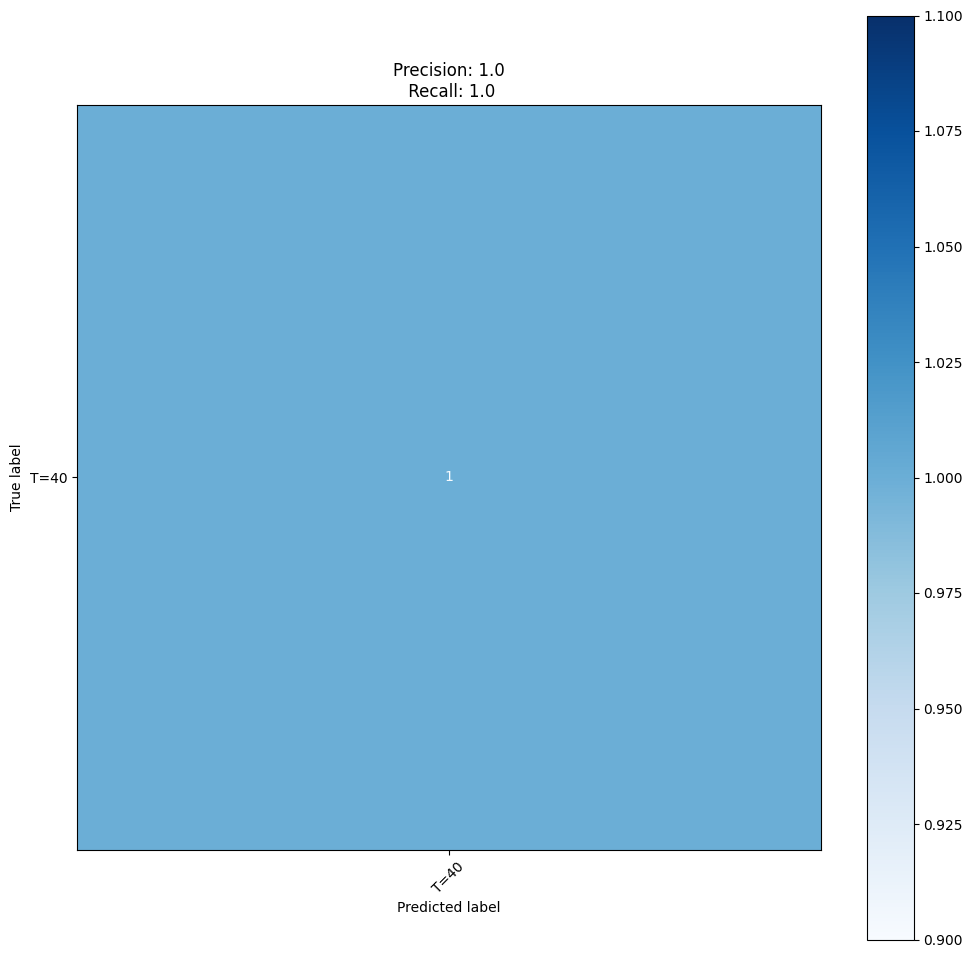

In [68]:
# labels = ['Period_U40', 'Period_40_45', 'Period_45_50', 'Period_50_55', 'Period_55_60', 'Period_60_65', 'Period_65_70', 'Period_70_75', 'Period_75_80', 'Period_80_85', 'Period_85_90', 'Period_90_95', 'Period_95_100']
labels = ['T=40']
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot()
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred, display_labels=labels, cmap='Blues', ax=ax, normalize='true', xticks_rotation=45)
print('Period=40 Recall %0.3f' % recall_score(y_valid, y_pred, average='weighted'))
print('Period=40 Precision %0.3f' % precision_score(y_valid, y_pred, average='weighted'))
plt.title(f'Precision: {np.round(precision_score(y_valid, y_pred, average="weighted"), 3)}\n Recall: {np.round(recall_score(y_valid, y_pred, average="weighted"), 3)}')
plt.show()

### Conclusion
The single frequency model serves as our 'perfect mdoel' where a single frequency from light curves that are evenly sampled in varing phases can be easily predicted and thus gives us a 100% precision and recall score.

## Part 2 Timeseries of Mulitple Frequency(at different phases)

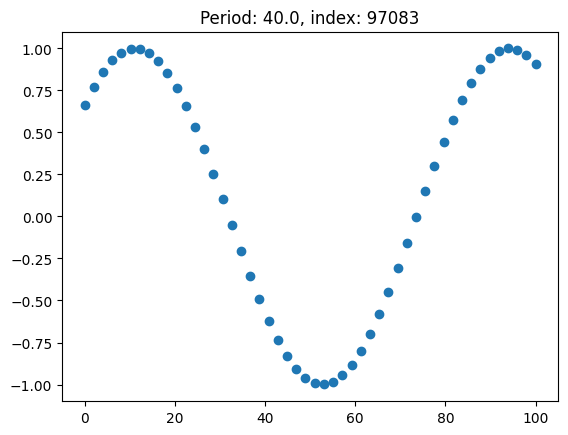

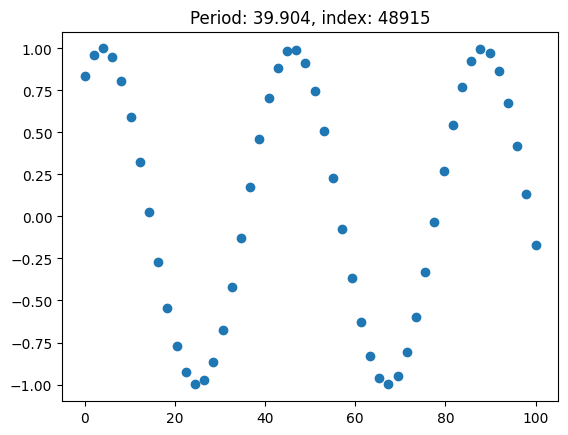

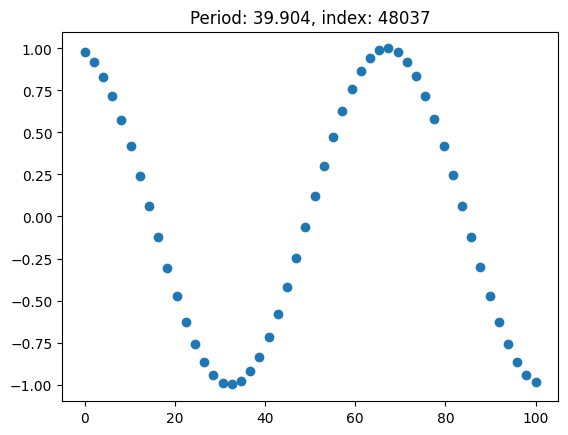

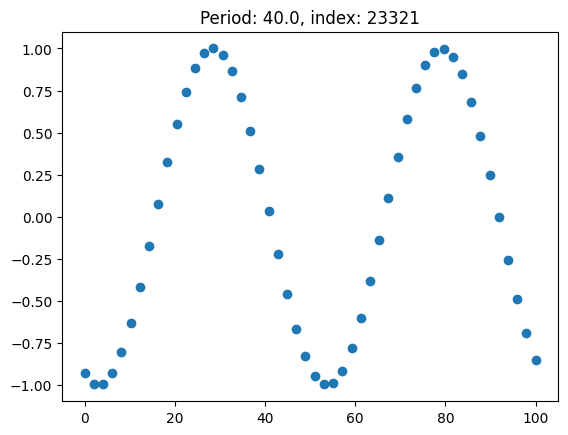

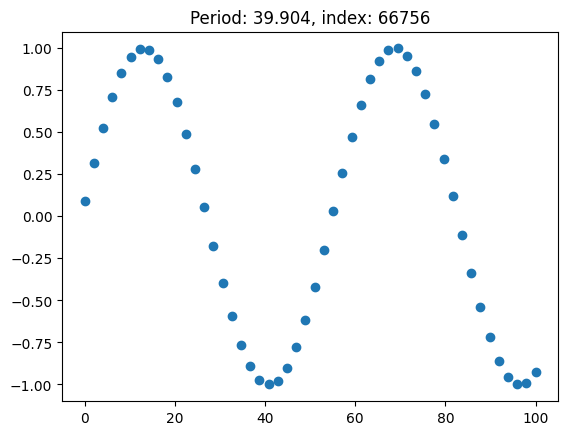

In [70]:
# ts_multi_freq_df = pd.read_feather('/Users/mmckay/Desktop/astr598_spr24_classification_repo/data/timeseries_multiple_frequency.feather')
# ts_multi_freq_df.head()
# plot_timeseries(ts_multi_freq_df, indx=10)
# plot_timeseries(ts_multi_freq_df, indx=25)
# plot_timeseries(ts_multi_freq_df, indx=200)

# Read in timesseries data
df_multiple = pd.read_feather('/Users/mmckay/Desktop/astr598_spr24_classification_repo/data/timeseries_multiple_frequency.feather')

for value in random.sample(range(1, 100001), 5):
    plt.title(f'Period: {np.round(periods[value], 3)}, index: {value}')
    plot_timeseries(df_multiple, indx=value)

### GMM for multi-frequency (same as above but compress to a single cell)
#### - there are 2 versions 2a and 2b
- 2a: Running cesium to compute features in the cell - (~30mins to complete)
- 2b: Reading the features from a saved .csv file from a pervious run of cesium (~30 secs)

### 2a: Running cesium to compute features in the cell - (~30mins to complete)

In [ ]:
# # periods = multifreq_fset_cesium['period_fast'].values[0][:]
# # %%time
# # Read in timesseries data
# df_multiple = pd.read_feather('/Users/mmckay/Desktop/astr598_spr24_classification_repo/data/timeseries_multiple_frequency.feather')

# # Set feature list you want from cesium 
features_to_use = [
    "amplitude",  # The half-difference between the maximum and minimum magnitude.
    "percent_beyond_1_std",  # The percentage of points beyond one standard deviation from the mean.
    "maximum",  # The maximum magnitude.
    "max_slope",  # The maximum absolute slope between two consecutive points.
    "median",  # The median magnitude.
    "median_absolute_deviation",  # The median absolute deviation of the magnitudes.
    "percent_close_to_median",  # The percentage of points within 10% of the median.
    "minimum",  # The minimum magnitude.
    "skew",  # The skewness of the magnitudes.
    "std",  # The standard deviation of the magnitudes.
    "period_fast",  # The period derived from a fast-fitting periodogram.
    "weighted_average",  # The weighted average of the magnitudes.
    "qso_log_chi2_qsonu",  # The logarithm of the chi-squared QSO statistic.
    "qso_log_chi2nuNULL_chi2nu",  # The logarithm of the difference between the chi-squared QSO statistic and its expected value.
    "fold2P_slope_10percentile",  # The 10th percentile of the slope distribution of a 2-phase folded light curve.
    "fold2P_slope_90percentile",  # The 90th percentile of the slope distribution of a 2-phase folded light curve.
    "freq1_amplitude1",  # The amplitude of the first harmonic of the first frequency in a Lomb-Scargle periodogram.
    "freq1_amplitude2",  # The amplitude of the second harmonic of the first frequency in a Lomb-Scargle periodogram.
    "freq1_amplitude3",  # The amplitude of the third harmonic of the first frequency in a Lomb-Scargle periodogram.
    "freq1_amplitude4",  # The amplitude of the fourth harmonic of the first frequency in a Lomb-Scargle periodogram.
    "freq1_freq",  # The first frequency in a Lomb-Scargle periodogram.
    "freq1_lambda",  # The regularization parameter used in the Lomb-Scargle periodogram for the first frequency.
    "freq1_rel_phase2",  # The phase of the second harmonic of the first frequency relative to the phase of the first harmonic.
    "freq1_rel_phase3",  # The phase of the third harmonic of the first frequency relative to the phase of the first harmonic.
    "freq1_rel_phase4",  # The phase of the fourth harmonic of the first frequency relative to the phase of the first harmonic.
    "freq1_signif",  # The significance of the first frequency in a Lomb-Scargle periodogram.
    "freq2_amplitude1",  # The amplitude of the first harmonic of the second frequency in a Lomb-Scargle periodogram.
    "freq2_amplitude2",  # The amplitude of the second harmonic of the second frequency in a Lomb-Scargle periodogram.
    "freq2_amplitude3",  # The amplitude of the third harmonic of the second frequency in a Lomb-Scargle periodogram.
    "freq2_amplitude4",  # The amplitude of the fourth harmonic of the second frequency in a Lomb-Scargle periodogram.
    "freq2_freq",  # The second frequency in a Lomb-Scargle periodogram.
    "freq2_rel_phase2",  # The phase of the second harmonic of the second frequency relative to the phase of the first harmonic.
    "freq2_rel_phase3",  # The phase of the third harmonic of the second frequency relative to the phase of the first harmonic.
    "freq2_rel_phase4",  # The phase of the fourth harmonic of the second frequency relative to the phase of the first harmonic.
    "freq3_amplitude1",  # The amplitude of the first harmonic of the third frequency in a Lomb-Scargle periodogram.
    "freq3_amplitude2",  # The amplitude of the second harmonic of the third frequency in a Lomb-Scargle periodogram.
    "freq3_amplitude3",  # The amplitude of the third harmonic of the third frequency in a Lomb-Scargle periodogram.
    "freq3_amplitude4",  # The amplitude of the fourth harmonic of the third frequency in a Lomb-Scargle periodogram.
    "freq3_freq",  # The third frequency in a Lomb-Scargle periodogram.
    "freq3_rel_phase2",  # The phase of the second harmonic of the third frequency relative to the phase of the first harmonic.
    "freq3_rel_phase3",  # The phase of the third harmonic of the third frequency relative to the phase of the first harmonic.
    "freq3_rel_phase4",  # The phase of the fourth harmonic of the third frequency relative to the phase of the first harmonic.
    "freq_y_offset",  # The y-offset of the Lomb-Scargle periodogram.
    "linear_trend",  # The slope of a linear fit to the light curve.
    "scatter_res_raw",  # The scatter of the residuals around a smoothed version of the light curve.
    "stetson_j",  # The Stetson J variability index.
    "stetson_k",  # The Stetson K variability index.
]


# # Create a list of cesium features including periods
# cesium_results=[]
# periods=[]

# for i in range(100000):
#     fset_cesium = featurize.featurize_time_series(
#         times=df_multiple[f'y'+str(i)].index[np.isfinite(df_multiple[f'y'+str(i)].values)],
#         values=df_multiple[f'y'+str(i)].values[np.isfinite(df_multiple[f'y'+str(i)].values)],
#         errors=None,
#         features_to_use=features_to_use,
#     )
    
#     cesium_results.append(fset_cesium)
#     periods.append(fset_cesium.period_fast.values[0][0])
    
    
# cesium_results[0]



# # Bin periods in to ranges to descitize the contiouns label    
# # cesium_results[0]
# classes=np.zeros(len(periods))
# for i in range(len(periods)):
#     classes[i]=int((np.array(periods[i])-40)/5)


# # periods = np.array(pd.read_pickle('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/periods_multiple_freq.pkl'))
# # Set features and truth labels - X, y for appending values
# X=np.zeros((len(periods), len(features_to_use)-1))
# y = classes
# print(f'y: {y}')
# labels = ['Period_U40', 'Period_40_45', 'Period_45_50', 'Period_50_55', 'Period_55_60', 'Period_60_65', 'Period_65_70', 
#           'Period_70_75', 'Period_75_80', 'Period_80_85', 'Period_85_90', 'Period_90_95', 'Period_95_100']


# for i in range(len(periods)):
#     X[i]= cesium_results[i]['amplitude'].values[0][0], cesium_results[i]['percent_beyond_1_std'].values[0][0], cesium_results[i]['maximum'].values[0][0], cesium_results[i]['max_slope'].values[0][0], cesium_results[i]['median'].values[0][0], cesium_results[i]['median_absolute_deviation'].values[0][0], cesium_results[i]['percent_close_to_median'].values[0][0], cesium_results[i]['minimum'].values[0][0], cesium_results[i]['skew'].values[0][0], cesium_results[i]['std'].values[0][0], cesium_results[i]['weighted_average'].values[0][0]   

# y = classes
# print(f'y: {y}')

# # Data Split
# (X_train, X_valid, X_test), (y_train, y_valid, y_test) = split_samples(X, y, [0.8, 0.1, 0.1], random_state=0)
# gmmb = GMMBayes(n_components=4, random_state=0)
# gmmb.fit(X_train, y_train)
# y_pred = gmmb.predict(X_valid)


# fig = plt.figure(figsize=(12,12))
# ax = fig.add_subplot()
# ConfusionMatrixDisplay.from_predictions(y_valid, y_pred, display_labels=labels, cmap='Blues', ax=ax, normalize='true', xticks_rotation=45)
# print('Stellar Type Recall %0.3f' % recall_score(y_valid, y_pred, average='weighted'))
# print('Stellar Type Precision %0.3f' % precision_score(y_valid, y_pred, average='weighted'))
# plt.title(f'Precision: {np.round(precision_score(y_valid, y_pred, average="weighted"), 3)}\n Recall: {np.round(recall_score(y_valid, y_pred, average="weighted"), 3)}')
# plt.show()

### 2b: Reading the features from a saved .csv file from a pervious run of cesium (~10 secs)

/var/folders/41/1_71sw_13ql14yq5j387scf80000gn/T/ipykernel_43948/2891554011.py:23: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_multiple = pd.read_csv('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/multiple_freq_cesium_features.csv')


X: (100000, 11), 
y: (100000,)
Stellar Type Recall 0.929
Stellar Type Precision 0.931


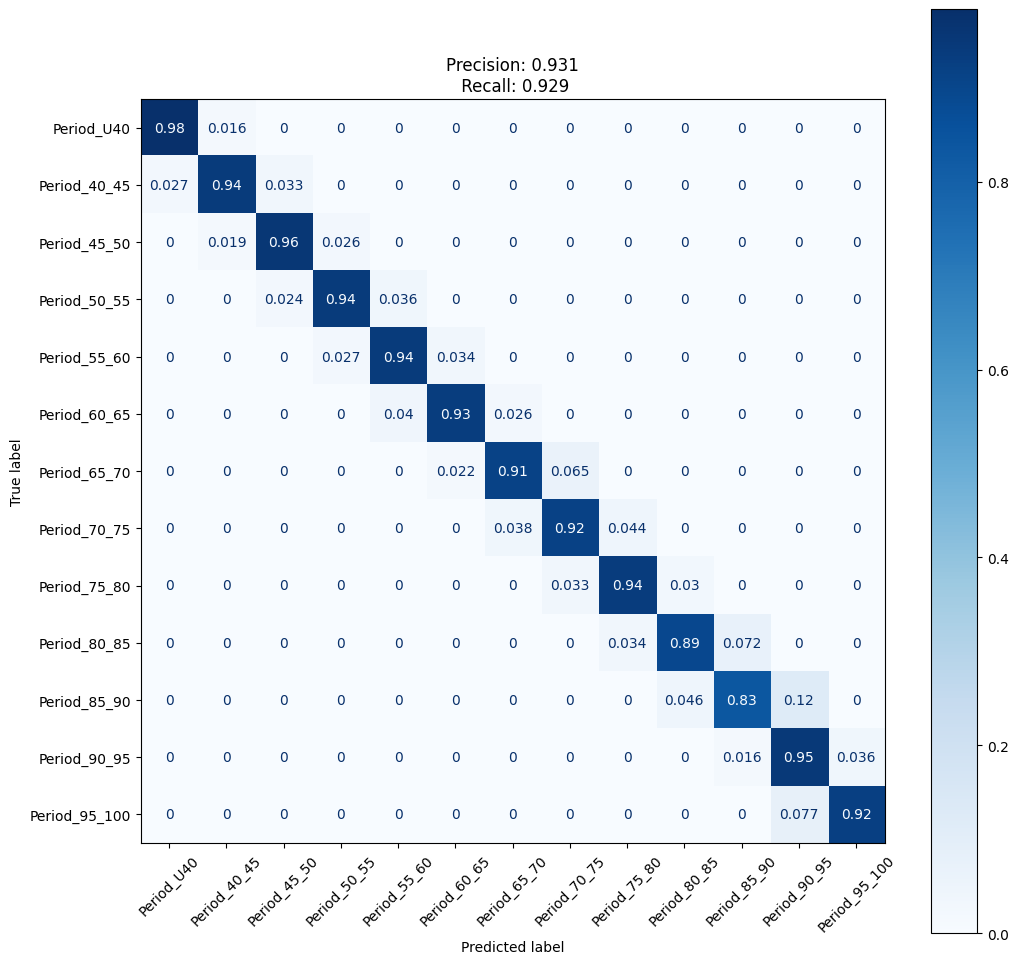

In [89]:
# periods = multifreq_fset_cesium['period_fast'].values[0][:]
# %%time
# Read in timesseries data
# df_multiple = pd.read_feather('/Users/mmckay/Desktop/astr598_spr24_classification_repo/data/timeseries_multiple_frequency.feather')

# Set feature list you want from cesium 
features_to_use = [
    "amplitude",
    "percent_beyond_1_std",
    "maximum",
    "max_slope",
    "median",
    "median_absolute_deviation",
    "percent_close_to_median",
    "minimum",
    "skew",
    "std",
    "period_fast",
    "weighted_average",
]


df_multiple = pd.read_csv('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/multiple_freq_cesium_features.csv')
periods = df_multiple['period_fast'].values[1:]

# Bin the periods into increments of 5
classes=np.zeros(len(periods))
for i in range(len(periods)):
    classes[i]=int((np.array(periods[i])-40)/5)
y = classes

# Select all values except the periods
X = df_multiple.drop(columns=['period_fast', 'feature']).values[1:]
print(f'X: {X.shape}, \ny: {y.shape}')

# Data Split
(X_train, X_valid, X_test), (y_train, y_valid, y_test) = split_samples(X, y, [0.8, 0.1, 0.1], random_state=0)

# GMM Classifier
gmmb = GMMBayes(n_components=8, random_state=0) # See cross-validation below for why we select 6 components
gmmb.fit(X_train, y_train)
y_pred = gmmb.predict(X_valid)

# 
labels = ['Period_U40', 'Period_40_45', 'Period_45_50', 'Period_50_55', 'Period_55_60', 'Period_60_65', 'Period_65_70', 'Period_70_75', 'Period_75_80', 'Period_80_85', 'Period_85_90', 'Period_90_95', 'Period_95_100']
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot()
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred, display_labels=labels, cmap='Blues', ax=ax, normalize='true', xticks_rotation=45)
print('Recall %0.3f' % recall_score(y_valid, y_pred, average='weighted'))
print('Precision %0.3f' % precision_score(y_valid, y_pred, average='weighted'))
plt.title(f'Precision: {np.round(precision_score(y_valid, y_pred, average="weighted"), 3)}\n Recall: {np.round(recall_score(y_valid, y_pred, average="weighted"), 3)}')
plt.show()

### Visualize features for multiple frequencies

<Figure size 2000x2000 with 0 Axes>

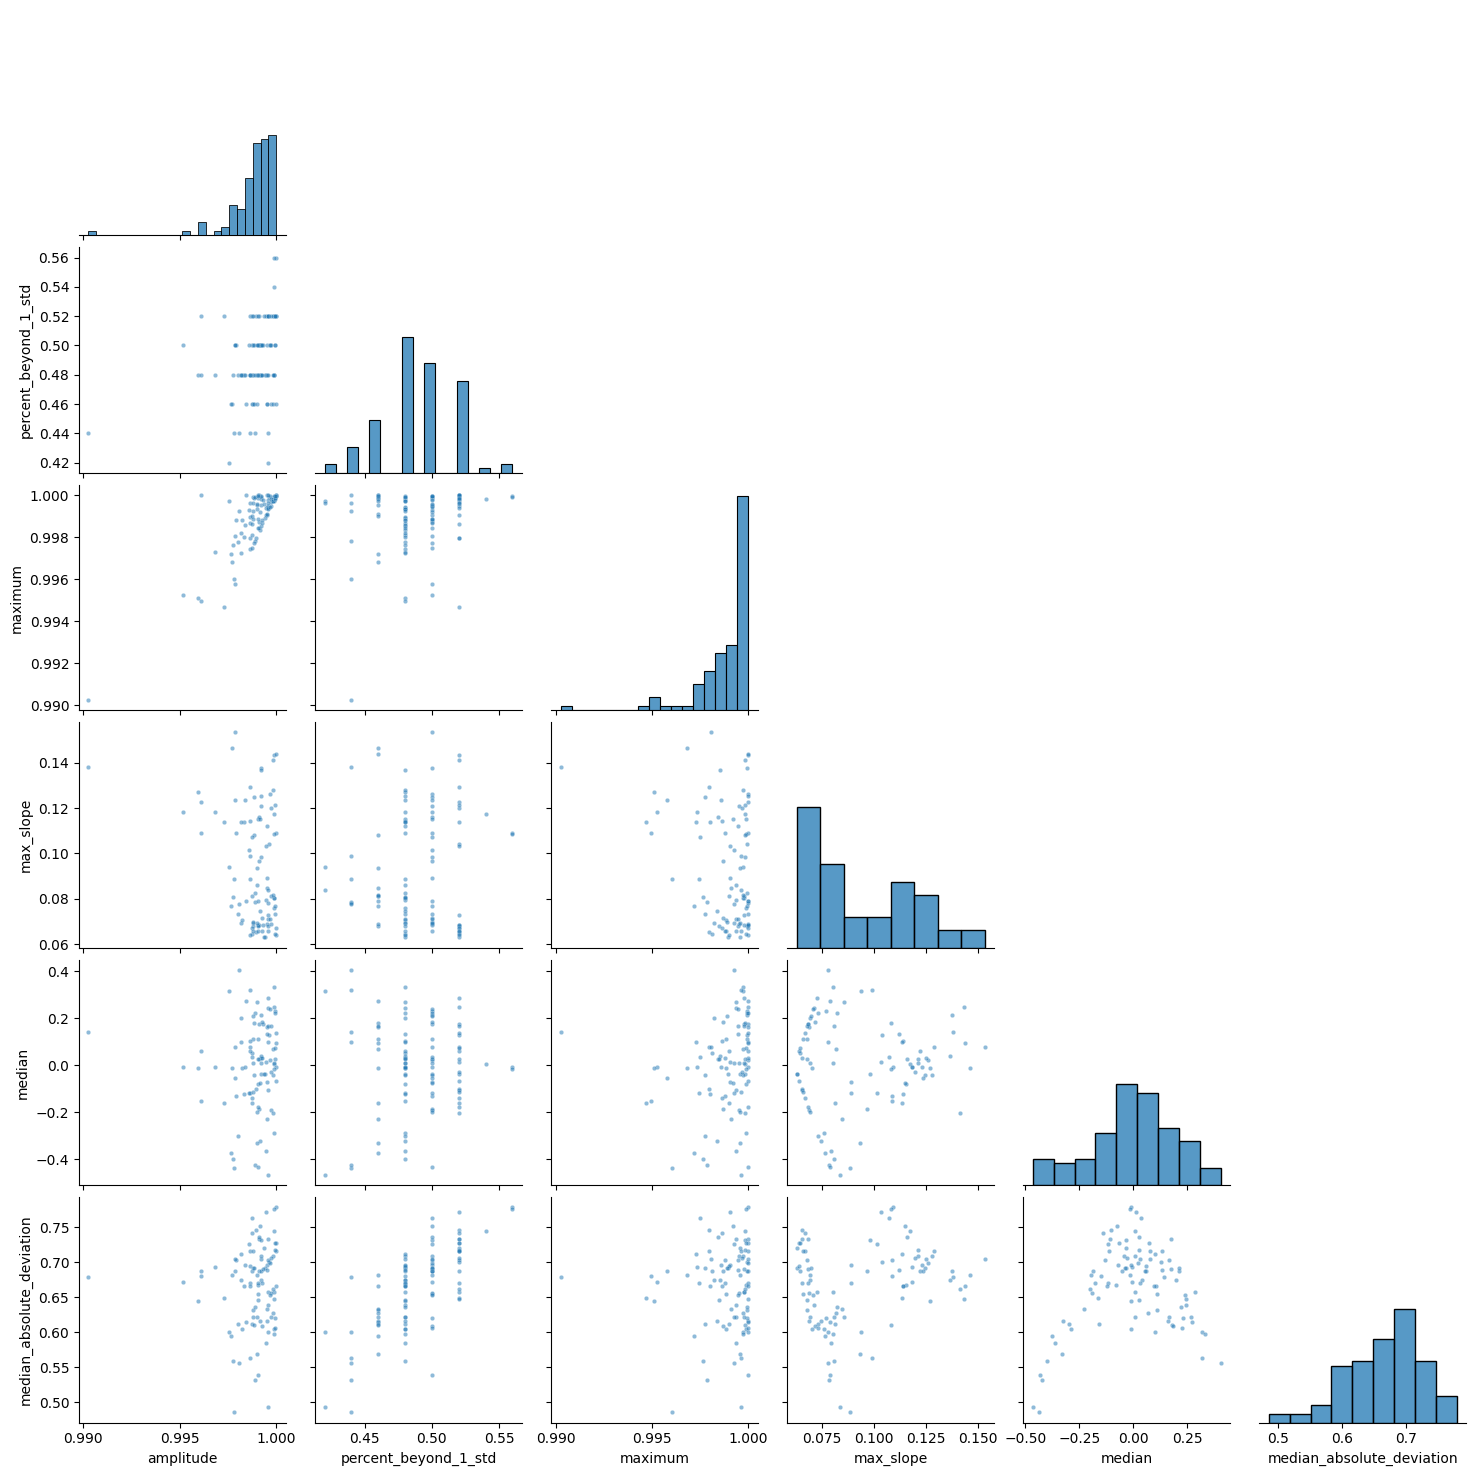

In [85]:
# Assuming your dataframe is named 'df'
sampled_df_multiple = df_multiple.sample(n=100, replace=False)

cols = ['amplitude', 'percent_beyond_1_std', 'maximum', 'max_slope',
       'median', 'median_absolute_deviation']
fig = plt.figure(figsize=(20,20))
sns.pairplot(sampled_df_multiple, 
            x_vars=cols,
            y_vars=cols,
            # hue='period_fast', palette='tab20',
            corner=True,
            plot_kws={'alpha':0.5, 's':10})

Text(0.5, 0, 'Period')

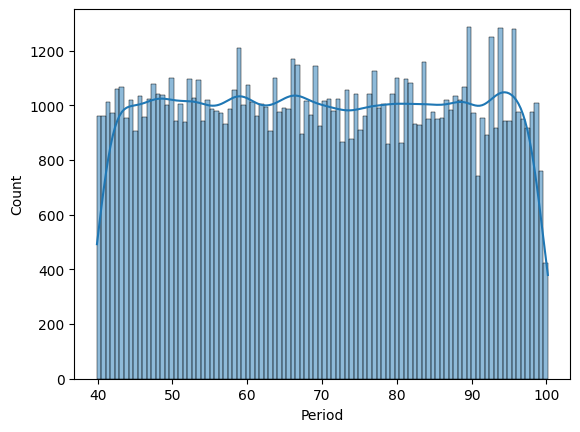

In [82]:
sns.histplot(df_multiple['period_fast'][1:], bins=100, kde=True)
plt.xlabel('Period')

#### Cross validation to select the right number of components
- Fit training model with different number of componets and see which one preformes best of the validation set and prevent under and over fitting

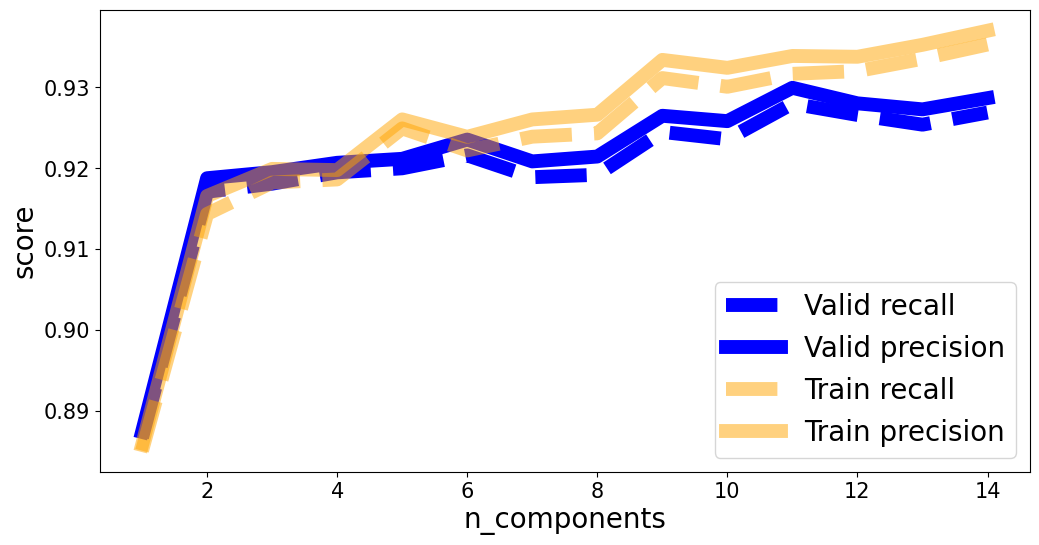

In [92]:
n_components = np.arange(1, 15)
recall_valid = np.zeros(n_components.shape)
precision_valid = np.zeros(n_components.shape)
recall_train = np.zeros(n_components.shape)
precision_train = np.zeros(n_components.shape)
for i, n in enumerate(n_components):
    gmmb = GMMBayes(n_components=n, random_state=0, reg_covar=1e-5)
    gmmb.fit(X_train, y_train)

    # validation set
    y_pred = gmmb.predict(X_valid)
    recall_valid[i] = recall_score(y_valid, y_pred, average='weighted')
    precision_valid[i] = precision_score(y_valid, y_pred, average='weighted')

    # training set
    y_pred_train = gmmb.predict(X_train)
    recall_train[i] = recall_score(y_train, y_pred_train, average='weighted')
    precision_train[i] = precision_score(y_train, y_pred_train, average='weighted')


fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
ax.plot(n_components, recall_valid, label='Valid recall', linewidth=10, color='blue', alpha=1, linestyle='--')
ax.plot(n_components, precision_valid, label='Valid precision', linewidth=10, color='blue', alpha=1)

ax.plot(n_components, recall_train, label='Train recall', linewidth=10, color='orange', alpha=0.5, linestyle='--')
ax.plot(n_components, precision_train, label='Train precision', linewidth=10, color='orange', alpha=0.5)
ax.set_xlabel('n_components', fontsize=20)
ax.set_ylabel('score', fontsize=20)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.legend(fontsize=20)
plt.show()

##### Cross-validation result: The indication that the number of components is appropriate is when the training and validation scores are similar and do not vary significantly with changes in adjacent components. This suggests that the model is not overly sensitive to the exact number of components.

## Part 3: Timeseries Multiple Frequency Sampled

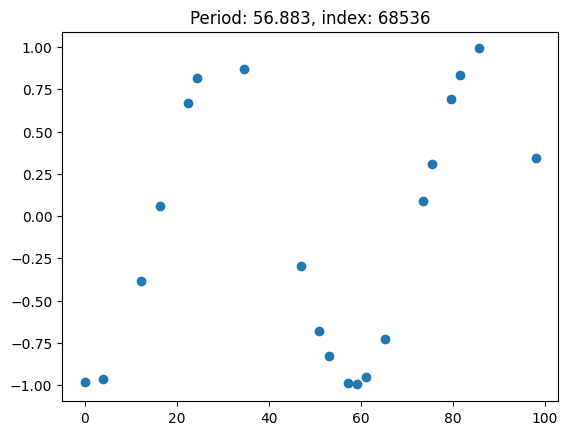

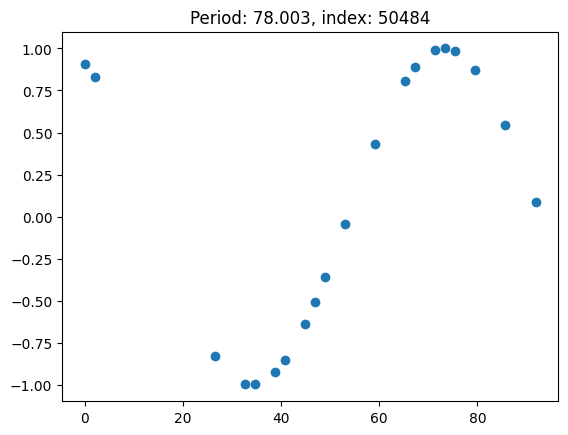

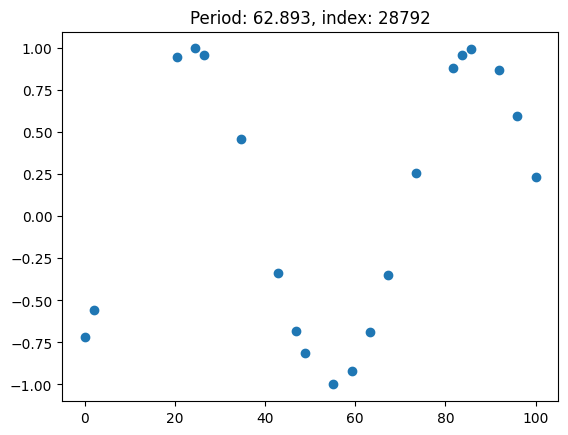

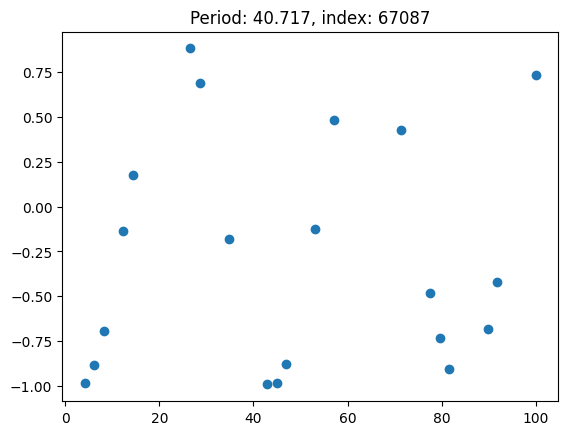

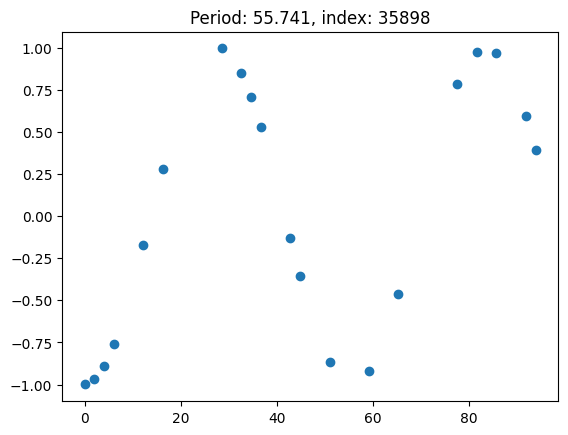

In [94]:
# Read in timesseries data
df_multiple_sampled = pd.read_feather('/Users/mmckay/Desktop/astr598_spr24_classification_repo/data/timeseries_multiple_frequency_sampled.feather')

for value in random.sample(range(1, 100001), 5):
    plt.title(f'Period: {np.round(periods[value], 3)}, index: {value}')
    plot_timeseries(df_single, indx=value)

### GMM for multi-frequency sampled (same as above but compress to a single cell)
#### - there are 2 versions 3a and 3b
- 2a: Running cesium to compute features in the cell - (~30mins to complete)
- 2b: Reading the features from a saved .csv file from a pervious run of cesium (~30 secs)

### 3a: Running cesium to compute features in the cell - (~30mins to complete)

y: [10.  9.  9. ...  2.  9.  9.]
y: [10.  9.  9. ...  2.  9.  9.]
Stellar Type Recall 0.843
Stellar Type Precision 0.843


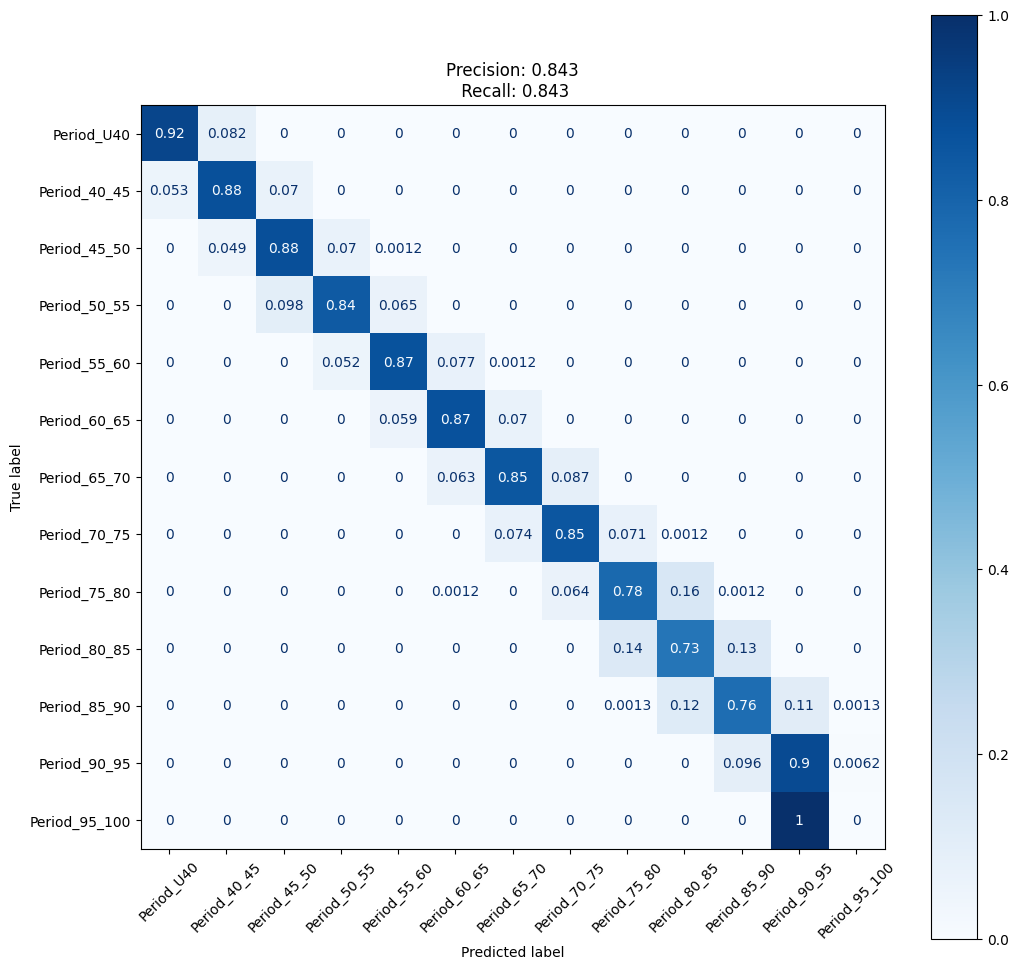

In [ ]:
# Read in timesseries data
df_multiple_sampled = pd.read_feather('/Users/mmckay/Desktop/astr598_spr24_classification_repo/data/timeseries_multiple_frequency_sampled.feather')

# Set feature list you want from cesium 
features_to_use = [
    "amplitude",
    "percent_beyond_1_std",
    "maximum",
    "max_slope",
    "median",
    "median_absolute_deviation",
    "percent_close_to_median",
    "minimum",
    "skew",
    "std",
    "period_fast",
    "weighted_average",
]


# Create a list of cesium features including periods
cesium_results=[]
periods=[]

for i in range(100000):
    fset_cesium = featurize.featurize_time_series(
        times=df_multiple[f'y'+str(i)].index[np.isfinite(df_multiple[f'y'+str(i)].values)],
        values=df_multiple[f'y'+str(i)].values[np.isfinite(df_multiple[f'y'+str(i)].values)],
        errors=None,
        features_to_use=features_to_use,
    )
    
    cesium_results.append(fset_cesium)
    periods.append(fset_cesium.period_fast.values[0][0])
    
    
cesium_results[0]



# Bin periods in to ranges to descitize the contiouns label    
# cesium_results[0]
classes=np.zeros(len(periods))
for i in range(len(periods)):
    classes[i]=int((np.array(periods[i])-40)/5)


# periods = np.array(pd.read_pickle('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/periods_multiple_freq.pkl'))
# Set features and truth labels - X, y for appending values
X=np.zeros((len(periods), len(features_to_use)-1))
y = classes
print(f'y: {y}')
labels = ['Period_U40', 'Period_40_45', 'Period_45_50', 'Period_50_55', 'Period_55_60', 'Period_60_65', 'Period_65_70', 'Period_70_75', 'Period_75_80', 'Period_80_85', 'Period_85_90', 'Period_90_95', 'Period_95_100']


for i in range(len(periods)):
    X[i]= cesium_results[i]['amplitude'].values[0][0], cesium_results[i]['percent_beyond_1_std'].values[0][0], cesium_results[i]['maximum'].values[0][0], cesium_results[i]['max_slope'].values[0][0], cesium_results[i]['median'].values[0][0], cesium_results[i]['median_absolute_deviation'].values[0][0], cesium_results[i]['percent_close_to_median'].values[0][0], cesium_results[i]['minimum'].values[0][0], cesium_results[i]['skew'].values[0][0], cesium_results[i]['std'].values[0][0], cesium_results[i]['weighted_average'].values[0][0]   

y = classes
print(f'y: {y}')

# Data Split
(X_train, X_valid, X_test), (y_train, y_valid, y_test) = split_samples(X, y, [0.8, 0.1, 0.1], random_state=0)

gmmb = GMMBayes(n_components=4, random_state=0)
gmmb.fit(X_train, y_train)

y_pred = gmmb.predict(X_valid)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot()
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred, display_labels=labels, cmap='Blues', ax=ax, normalize='true', xticks_rotation=45)
print('Stellar Type Recall %0.3f' % recall_score(y_valid, y_pred, average='weighted'))
print('Stellar Type Precision %0.3f' % precision_score(y_valid, y_pred, average='weighted'))
plt.title(f'Precision: {np.round(precision_score(y_valid, y_pred, average="weighted"), 3)}\n Recall: {np.round(recall_score(y_valid, y_pred, average="weighted"), 3)}')
plt.show()

### 2b: Reading the features from a saved .csv file from a pervious run of cesium (~30 secs)

/var/folders/41/1_71sw_13ql14yq5j387scf80000gn/T/ipykernel_43948/3261928729.py:23: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_multiple_sampled = pd.read_csv('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/multi_freq_sampled_cesium_features.csv')


X: (100000, 11), 
y: (100000,)
Recall 0.871
Precision 0.872


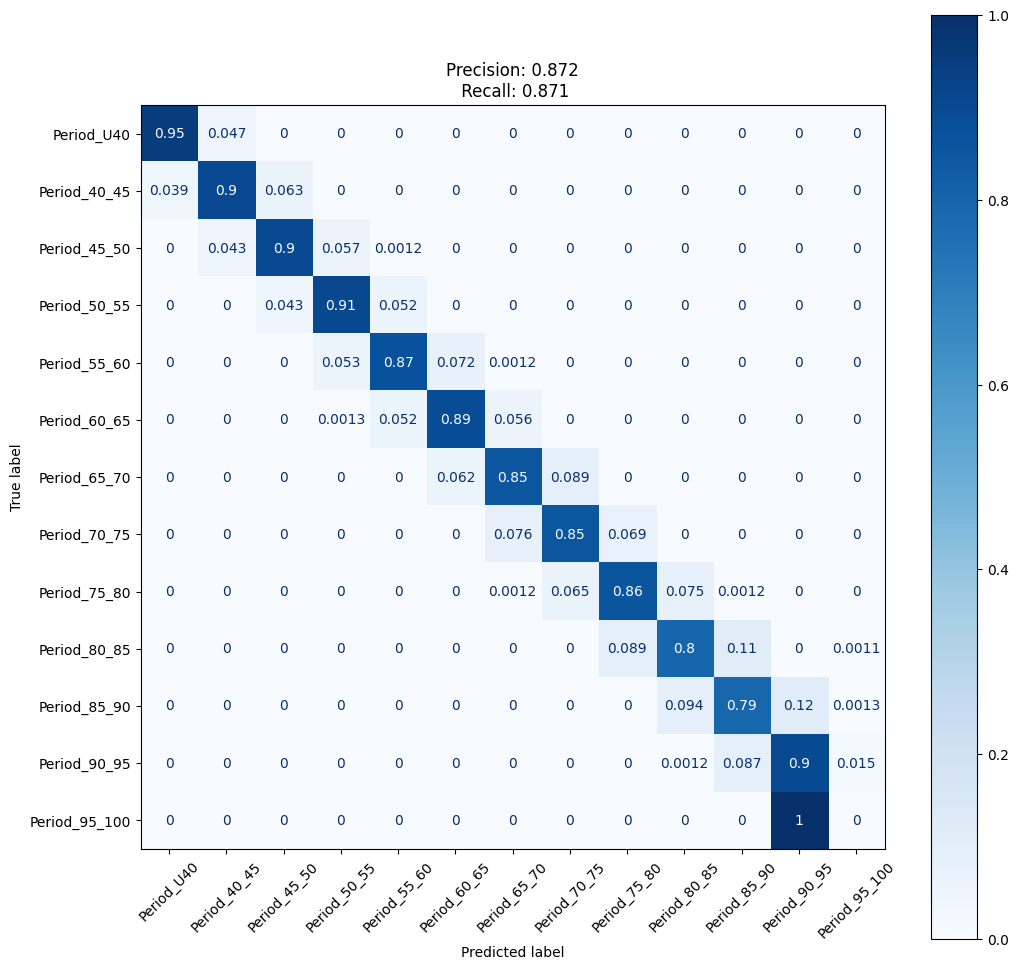

In [108]:
# periods = multifreq_fset_cesium['period_fast'].values[0][:]
# %%time
# Read in timesseries data
# df_multiple_sampled = pd.read_feather('/Users/mmckay/Desktop/astr598_spr24_classification_repo/data/timeseries_multiple_frequency.feather')

# Set feature list you want from cesium 
features_to_use = [
    "amplitude",
    "percent_beyond_1_std",
    "maximum",
    "max_slope",
    "median",
    "median_absolute_deviation",
    "percent_close_to_median",
    "minimum",
    "skew",
    "std",
    "period_fast",
    "weighted_average",
]


df_multiple_sampled = pd.read_csv('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/multi_freq_sampled_cesium_features.csv')
periods = df_multiple_sampled['period_fast'].values[1:]

# Bin the periods into increments of 5
classes=np.zeros(len(periods))
for i in range(len(periods)):
    classes[i]=int((np.array(periods[i])-40)/5)
y = classes

# Select all values except the periods
X = df_multiple_sampled.drop(columns=['period_fast', 'feature']).values[1:]
print(f'X: {X.shape}, \ny: {y.shape}')

# Data Split
(X_train, X_valid, X_test), (y_train, y_valid, y_test) = split_samples(X, y, [0.8, 0.1, 0.1], random_state=0)

# GMM Classifier
gmmb = GMMBayes(n_components=3, random_state=0) # See cross-validation below for why we select 6 components
gmmb.fit(X_train, y_train)
y_pred = gmmb.predict(X_valid)

# 
labels = ['Period_U40', 'Period_40_45', 'Period_45_50', 'Period_50_55', 'Period_55_60', 'Period_60_65', 'Period_65_70', 'Period_70_75', 'Period_75_80', 'Period_80_85', 'Period_85_90', 'Period_90_95', 'Period_95_100']
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot()
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred, display_labels=labels, cmap='Blues', ax=ax, normalize='true', xticks_rotation=45)
print('Recall %0.3f' % recall_score(y_valid, y_pred, average='weighted'))
print('Precision %0.3f' % precision_score(y_valid, y_pred, average='weighted'))
plt.title(f'Precision: {np.round(precision_score(y_valid, y_pred, average="weighted"), 3)}\n Recall: {np.round(recall_score(y_valid, y_pred, average="weighted"), 3)}')
plt.show()

### Visualize features for multiple frequencies

<Figure size 2000x2000 with 0 Axes>

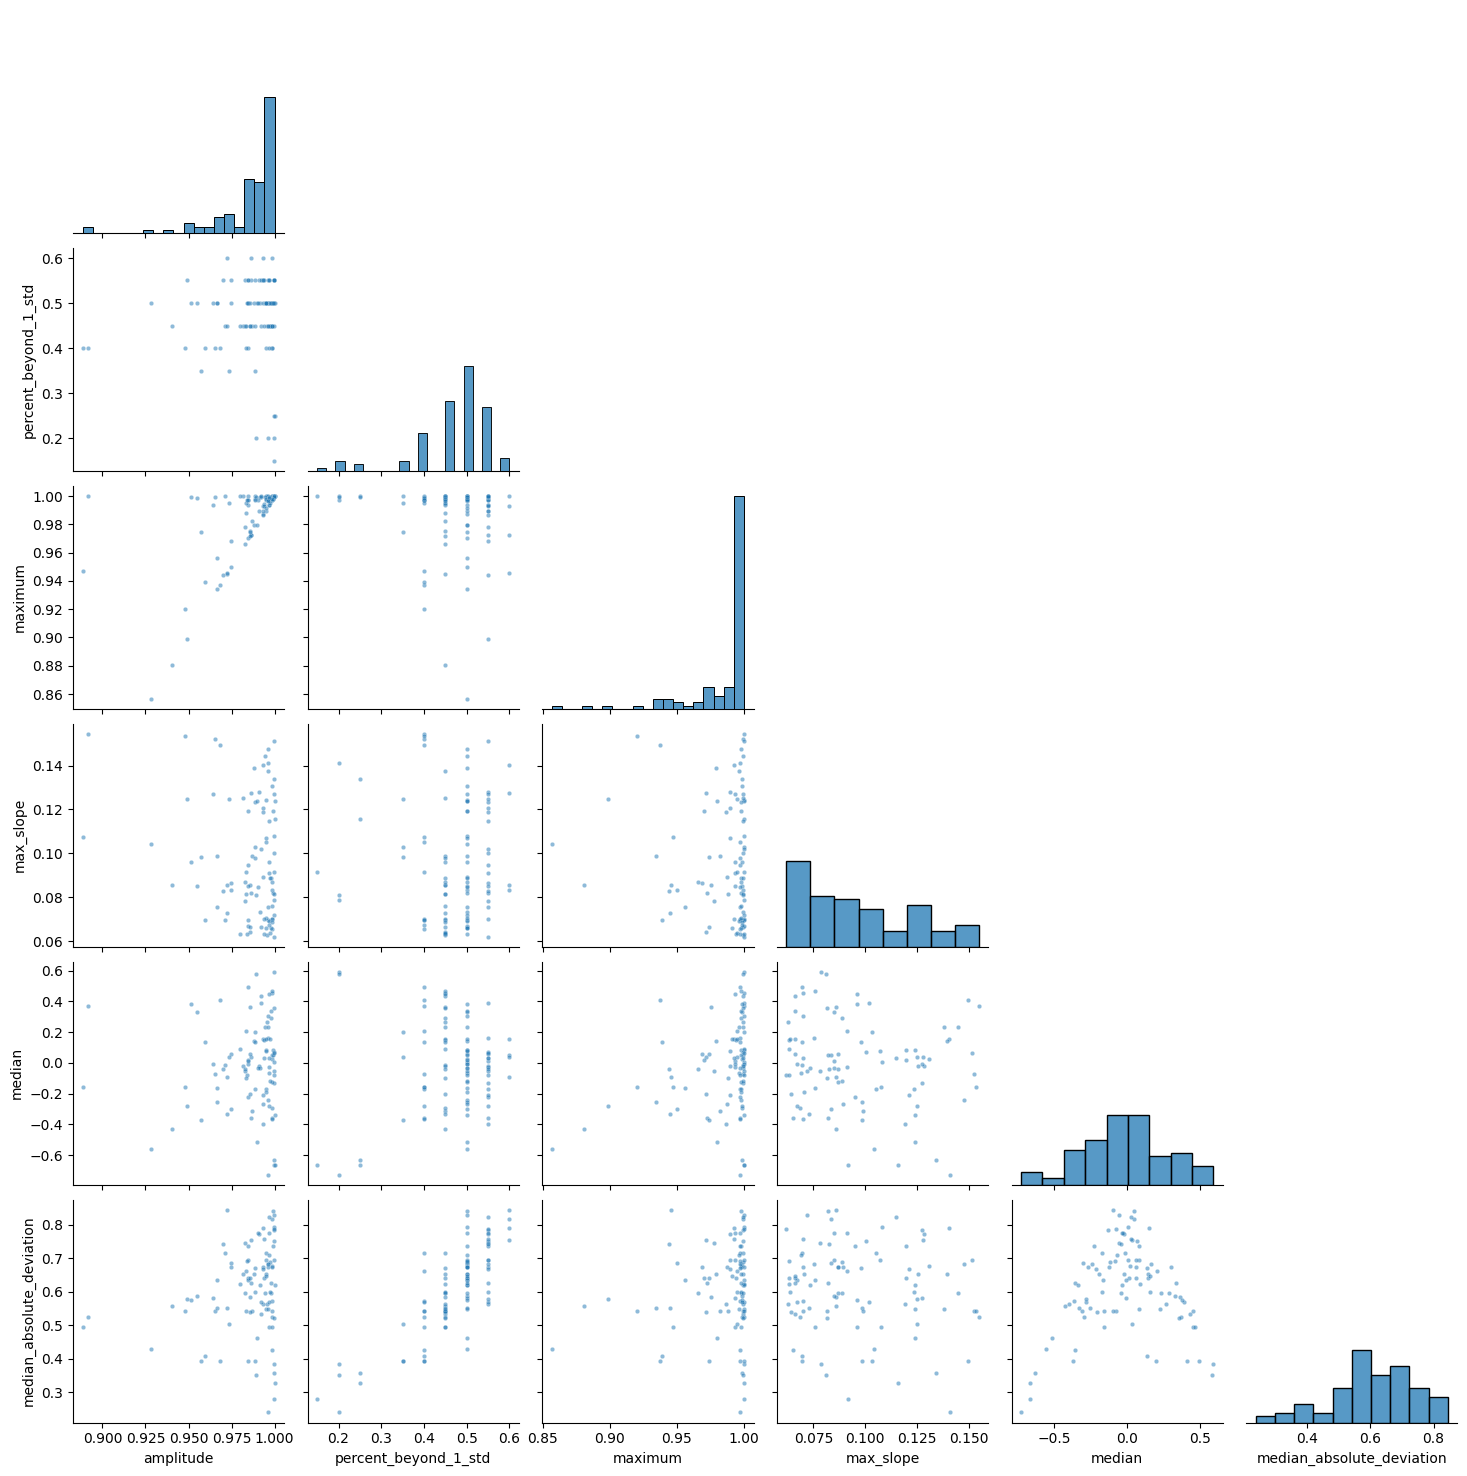

In [97]:
# Assuming your dataframe is named 'df'
sampled_df_multiple_sampled = df_multiple_sampled.sample(n=100, replace=False)

cols = ['amplitude', 'percent_beyond_1_std', 'maximum', 'max_slope',
       'median', 'median_absolute_deviation']
fig = plt.figure(figsize=(20,20))
sns.pairplot(sampled_df_multiple_sampled, 
            x_vars=cols,
            y_vars=cols,
            # hue='period_fast', palette='tab20',
            corner=True,
            plot_kws={'alpha':0.5, 's':10})

Text(0.5, 0, 'Period')

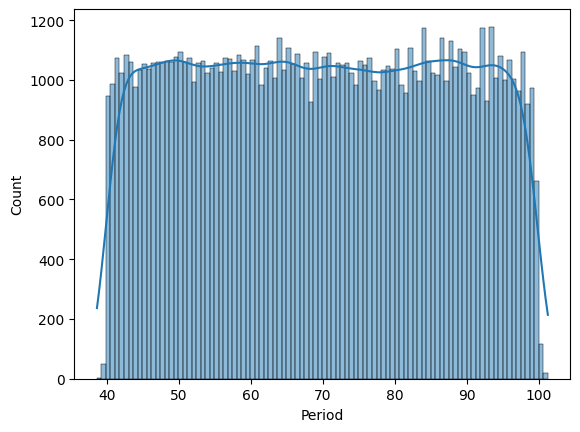

In [99]:
sns.histplot(df_multiple_sampled['period_fast'][1:], bins=100, kde=True)
plt.xlabel('Period')

#### Cross validation to select the right number of components
- Fit training model with different number of componets and see which one preformes best of the validation set and prevent under and over fitting

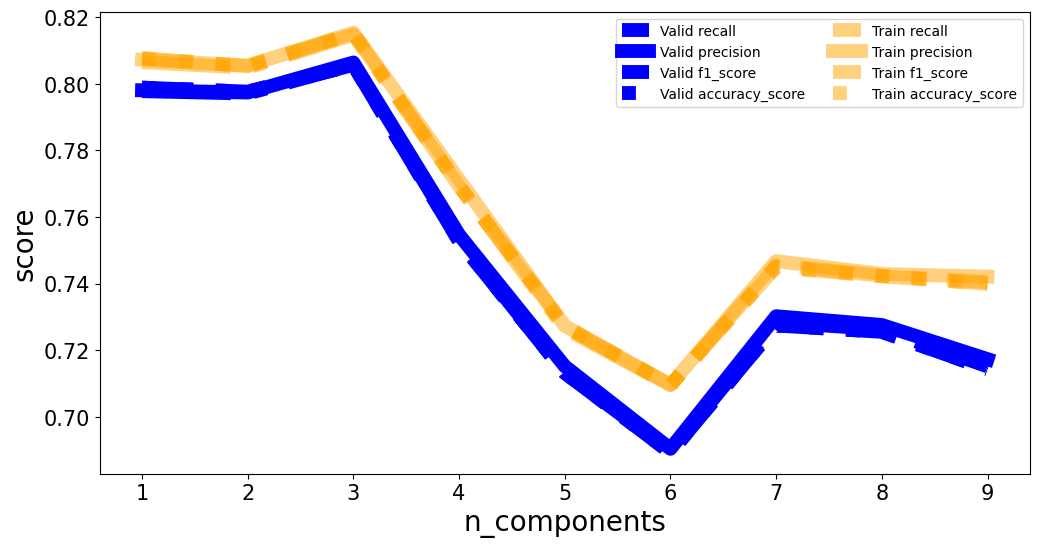

In [109]:
n_components = np.arange(1, 10)
recall_valid = np.zeros(n_components.shape)
precision_valid = np.zeros(n_components.shape)
f1_score_valid = np.zeros(n_components.shape)
accuracy_score_valid = np.zeros(n_components.shape)


recall_train = np.zeros(n_components.shape)
precision_train = np.zeros(n_components.shape)
f1_score_train = np.zeros(n_components.shape)
accuracy_score_train = np.zeros(n_components.shape)

for i, n in enumerate(n_components):
    gmmb = GMMBayes(n_components=n, random_state=0, reg_covar=1e-5)
    gmmb.fit(X_train, y_train)

    # validation set
    y_pred = gmmb.predict(X_valid)
    recall_valid[i] = recall_score(y_valid, y_pred, average='weighted')
    precision_valid[i] = precision_score(y_valid, y_pred, average='weighted')
    f1_score_valid[i] = f1_score(y_valid, y_pred, average='weighted')
    accuracy_score_valid[i] = accuracy_score(y_valid, y_pred)

    # training set
    y_pred_train = gmmb.predict(X_train)
    recall_train[i] = recall_score(y_train, y_pred_train, average='weighted')
    precision_train[i] = precision_score(y_train, y_pred_train, average='weighted')
    f1_score_train[i] = f1_score(y_train, y_pred_train, average='weighted')
    accuracy_score_train[i] = accuracy_score(y_train, y_pred_train)





fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()

# Validation
ax.plot(n_components, recall_valid, label='Valid recall', linewidth=10, color='blue', alpha=1, linestyle='--')
ax.plot(n_components, precision_valid, label='Valid precision', linewidth=10, color='blue', alpha=1)
ax.plot(n_components, f1_score_valid, label='Valid f1_score', linewidth=10, color='blue', alpha=1, linestyle='-.')
ax.plot(n_components, accuracy_score_valid, label='Valid accuracy_score', linewidth=10, color='blue', alpha=1, linestyle=':')

# Training
ax.plot(n_components, recall_train, label='Train recall', linewidth=10, color='orange', alpha=0.5, linestyle='--')
ax.plot(n_components, precision_train, label='Train precision', linewidth=10, color='orange', alpha=0.5)
ax.plot(n_components, f1_score_train, label='Train f1_score', linewidth=10, color='orange', alpha=0.5, linestyle='-.')
ax.plot(n_components, accuracy_score_train, label='Train accuracy_score', linewidth=10, color='orange', alpha=0.5, linestyle=':')

ax.set_xlabel('n_components', fontsize=20)
ax.set_ylabel('score', fontsize=20)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.legend(fontsize=10, ncol=2)
plt.show()

#### From the cross-validation results, we observe that after 3 components, the performance metrics decrease from 80% to 72%, which may indicate overfitting. Our aim is to maximize the performance of the model, so we will use 3 components.

## Part 4: Plasticc lightcurves

In [3]:
# df = pd.read_csv('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/plasticc_train_lightcurves.csv')
# df_meta = pd.read_csv('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/plasticc_train_metadata.csv')
# df_names = pd.read_csv('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/plasticc_train_target_names.csv')
# plasticc_lightcurve_features_df = pd.read_csv('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/Plasticc_LC_features_stellar_parm.csv')


# # group lightcurves by object_id
# grouped = df.groupby('object_id')
# i = 0
# series_list = []
# series_names = []
# for group, data in grouped:
#     condition = (data['passband'] == 2) & (data['detected_bool'] == 1)
    
#     flux = data.loc[condition, 'flux']
#     mjd = data.loc[condition, 'mjd']

#     ser = pd.Series(data=flux.values, index=mjd)
#     if (len(ser) > 15):
#         series_list.append(ser)
#         series_names.append(group)
#         i += 1

# dataDict =  dict(zip(series_names, series_list))

# # file_path = 'plasticc_lightcurves_g.pkl'
# # with open(file_path, 'wb') as file:
# #     pickle.dump(dataDict, file)

# df_selected = df_meta[df_meta['object_id'].isin(series_names)]
# # file_path = 'plasticc_lightcurves_g_metadata.pkl'
# # df_selected.to_pickle(file_path)

# print (len(dataDict))

# df_selected.loc[:, 'tflux_u-g'] = df_selected['tflux_u'] - df_selected['tflux_g']
# df_selected.loc[:, 'tflux_g-r'] = df_selected['tflux_g'] - df_selected['tflux_r']
# df_selected.loc[:, 'tflux_r-i'] = df_selected['tflux_r'] - df_selected['tflux_i']
# df_selected.loc[:, 'tflux_i-z'] = df_selected['tflux_i'] - df_selected['tflux_z']

# df_selected = plasticc_lightcurve_features_df.merge(df_selected, on='object_id', suffixes=('', '_y'))



# df_selected = df_selected[df_selected.columns.drop(list(df_selected.filter(regex='_y')))]
# # df_selected.to_csv('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/Plasticc_LC_features_stellar_parm.csv')
# print(f'Dropped duplicate rows {df_selected.shape}')


# # Drop all values with flux <= 0
# # df_selected.dropna(subset=['tflux_u', 'tflux_g', 'tflux_r', 'tflux_i', 'tflux_z'], inplace=True)

# # df_selected = df_selected[df_selected[['tflux_u', 'tflux_g', 'tflux_r', 'tflux_i', 'tflux_z']] != np.nan]

# # print(f'Removed nan values in flux dataframe {df_selected.shape}')

# # df_selected = df_selected[df_selected[['tflux_u', 'tflux_g', 'tflux_r', 'tflux_i', 'tflux_z']] > 0]
# # print(f'Removed 0 values in flux dataframe {df_selected.shape}')


# X, y = df_selected[['tflux_u-g', 'tflux_g-r', 'tflux_r-i', 'tflux_i-z','true_vpec', 'true_rv', 'true_av', 'true_distmod', 'true_lensdmu', 'feature', 'amplitude', 'percent_beyond_1_std', 'maximum', 'max_slope', 'median', 'median_absolute_deviation', 'percent_close_to_median', 'minimum', 'skew', 'std', 'period_fast', 'weighted_average',]], df_selected['target']

# labels = np.unique(df_names['target']).tolist()
# print('X.shape', X.shape)
# print('y.shape', y.shape)



# # split our data into training and validation sets
# # setting random_state makes this split deterministic
# (X_plasticc_train, X_plasticc_valid, X_plasticc_test), (y_plasticc_train, y_plasticc_valid, y_plasticc_test) = split_samples(X, y, [0.8, 0.1, 0.1], random_state=0)

# # train a Gaussian Mixture Bayes classifier with 2 gaussians for each class
# gmmb = GMMBayes(n_components=9, random_state=0)
# gmmb.fit(X_plasticc_train, y_plasticc_train)
# print(f'Accuracy: {gmmb.score(X_plasticc_valid, y_plasticc_valid)}')

# y_plasticc_pred = gmmb.predict(X_plasticc_valid)
# labels_list = np.unique(y_plasticc_valid)

# print(classification_report(y_plasticc_valid, y_plasticc_pred))
# print(labels_list)

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot()
# ConfusionMatrixDisplay.from_predictions(y_plasticc_valid, y_plasticc_pred, display_labels=labels_list, cmap='Blues', ax=ax, normalize='true')
# print('Stellar Type Recall %0.3f' % recall_score(y_plasticc_valid, y_plasticc_pred, average='weighted'))
# print('Stellar Type Precision %0.3f' % precision_score(y_plasticc_valid, y_plasticc_pred, average='weighted'))
# plt.title(f'Precision: {np.round(precision_score(y_plasticc_valid, y_plasticc_pred, average="weighted"), 3)}\n Recall: {np.round(recall_score(y_plasticc_valid, y_plasticc_pred, average="weighted"), 3)}')
# plt.show()

#### Visualize the plastic dataset

target
16.0    299
88.0    228
92.0    224
90.0    120
65.0     90
Name: count, dtype: int64


<Axes: xlabel='target', ylabel='Count'>

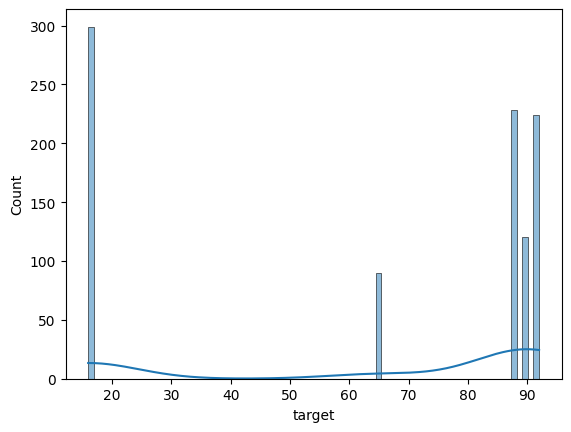

In [144]:
lightcurve_features_df = pd.read_csv('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/Plasticc_LC_features_stellar_parm.csv')

# preprocessing
counts = lightcurve_features_df['target'].value_counts()
to_keep = counts[counts > 80].index
lightcurve_features_df = lightcurve_features_df[lightcurve_features_df['target'].isin(to_keep)]
print(lightcurve_features_df['target'].value_counts())

sns.histplot(lightcurve_features_df['target'], bins=80, kde=True)

<Figure size 2000x2000 with 0 Axes>

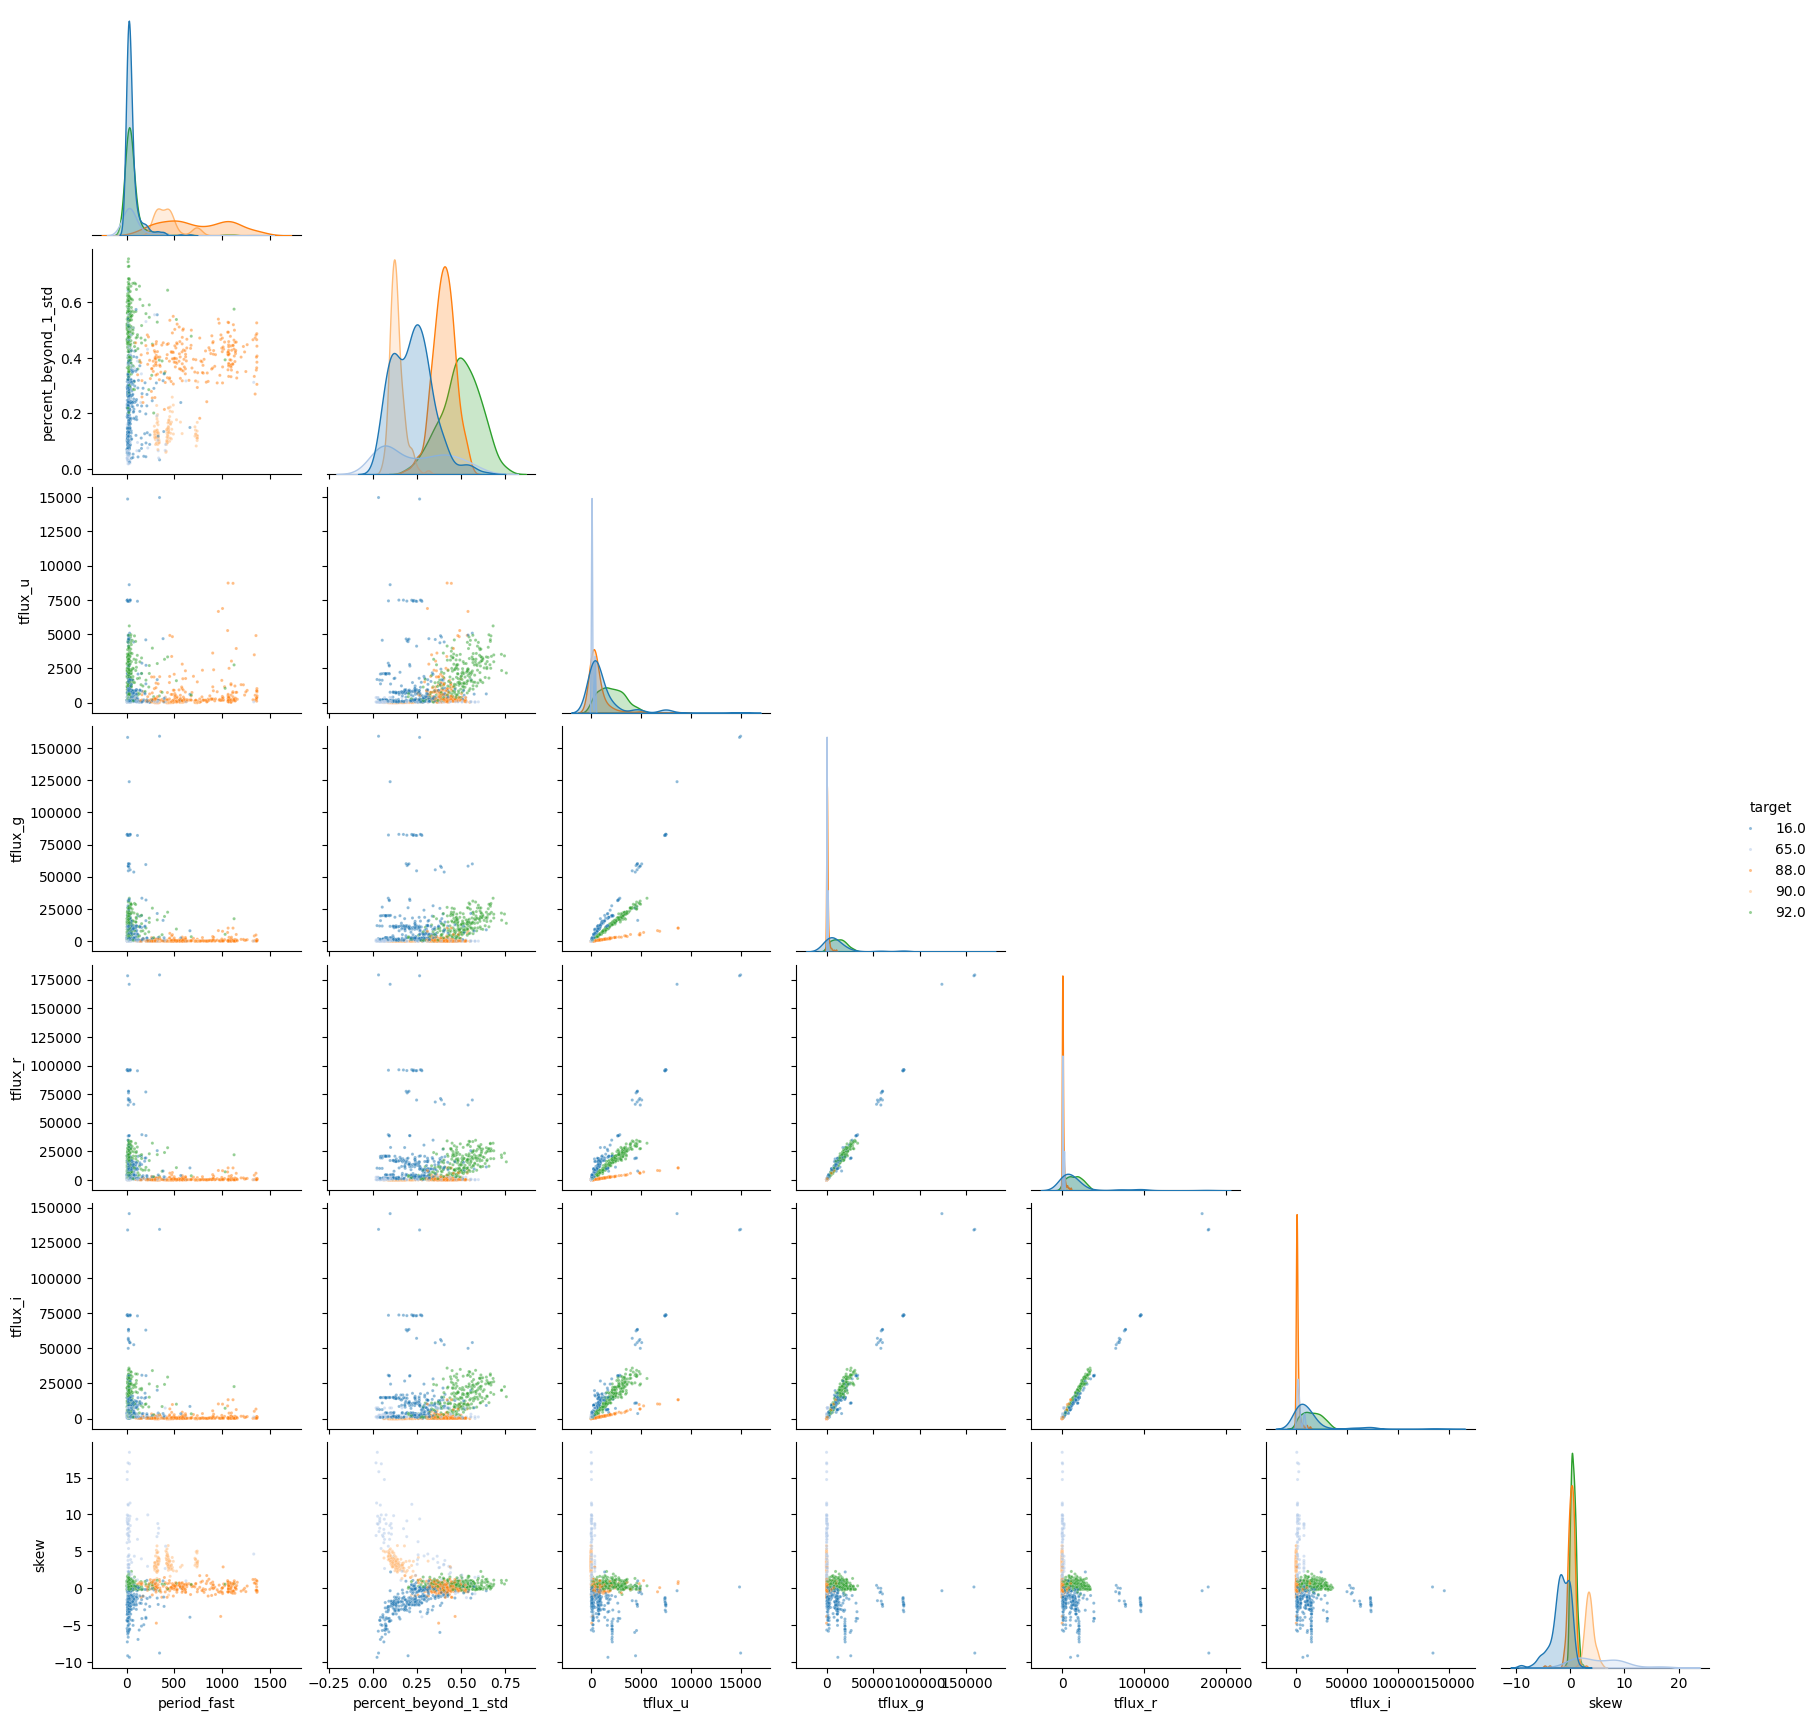

In [145]:
cols = ['period_fast',
 'percent_beyond_1_std',
 'tflux_u',
 'tflux_g',
 'tflux_r',
 'tflux_i',
 'skew']
fig = plt.figure(figsize=(20,20))
sns.pairplot(lightcurve_features_df, 
            x_vars=cols,
            y_vars=cols,
            hue='target', palette='tab20',
            corner=True,
            plot_kws={'alpha':0.5, 's':5})



target
16.0    299
88.0    228
92.0    224
90.0    120
Name: count, dtype: int64
X.shape (871, 21)
y.shape (871,)
              precision    recall  f1-score   support

        16.0       0.97      0.97      0.97        35
        88.0       0.94      1.00      0.97        17
        90.0       1.00      0.75      0.86         8
        92.0       0.93      0.96      0.95        27

    accuracy                           0.95        87
   macro avg       0.96      0.92      0.94        87
weighted avg       0.96      0.95      0.95        87

Stellar Type Recall 0.954
Stellar Type Precision 0.955


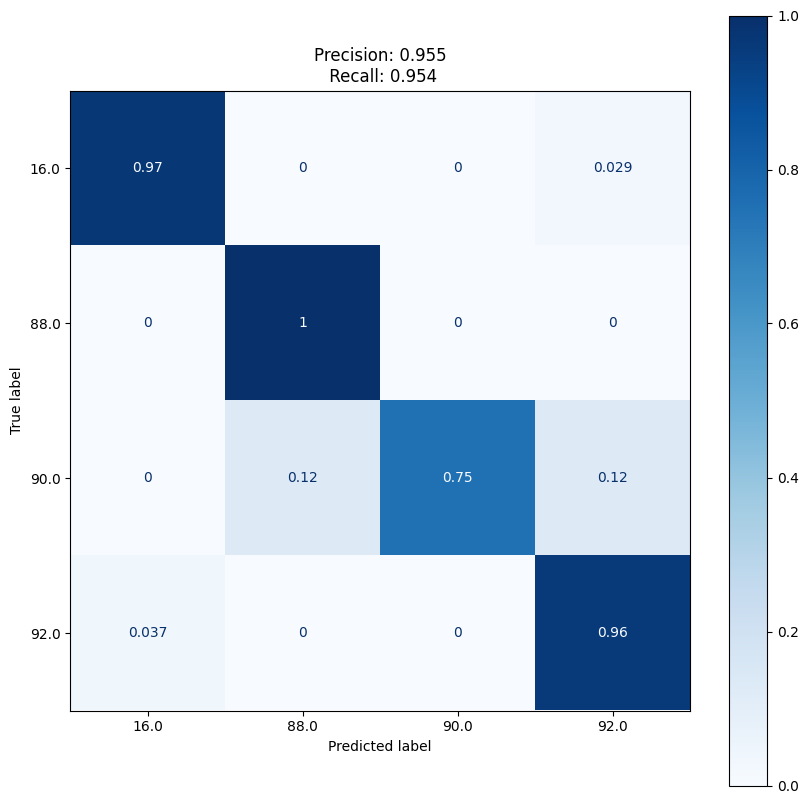

In [162]:
lightcurve_features_df = pd.read_csv('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/Plasticc_LC_features_stellar_parm.csv')

# preproceessing:
# - 
counts = lightcurve_features_df['target'].value_counts()
to_keep = counts[counts > 100].index
lightcurve_features_df = lightcurve_features_df[lightcurve_features_df['target'].isin(to_keep)]
lightcurve_features_df
print(lightcurve_features_df['target'].value_counts())

lightcurve_features_df.head()
lightcurve_features_df.loc[:, 'tflux_u-g'] = lightcurve_features_df['tflux_u'] - lightcurve_features_df['tflux_g']
lightcurve_features_df.loc[:, 'tflux_g-r'] = lightcurve_features_df['tflux_g'] - lightcurve_features_df['tflux_r']
lightcurve_features_df.loc[:, 'tflux_r-i'] = lightcurve_features_df['tflux_r'] - lightcurve_features_df['tflux_i']
lightcurve_features_df.loc[:, 'tflux_i-z'] = lightcurve_features_df['tflux_i'] - lightcurve_features_df['tflux_z']
# columns = lightcurve_features_df.columns.to_list() 
# column_without_target = [col for col in columns if col != 'target']
# column_without_target
# len(column_without_target)
# fetch the data and print its dimensions
X, y = lightcurve_features_df[['feature',
 'amplitude',
 'percent_beyond_1_std',
 'maximum',
 'max_slope',
 'median',
 'median_absolute_deviation',
 'percent_close_to_median',
 'minimum',
 'skew',
 'std',
 'period_fast',
 'weighted_average',
 'tflux_u',
 'tflux_g',
 'tflux_r',
 'tflux_i',
 'tflux_u-g',
 'tflux_g-r',
 'tflux_r-i',
 'tflux_i-z']], lightcurve_features_df['target']

# features = ['u-g', 'g-r', 'r-i', 'i-z']
# labels = ['non-variable', 'RR Lyrae']
labels = np.unique(lightcurve_features_df['target']).tolist()
print('X.shape', X.shape)
print('y.shape', y.shape)

# split our data into training and validation sets
# setting random_state makes this split deterministic
(X_train, X_valid, X_test), (y_train, y_valid, y_test) = split_samples(X, y, [0.8, 0.1, 0.1], random_state=42)
labels = np.unique(y_valid).astype('str')


# train a Gaussian Mixture Bayes classifier with 2 gaussians for each class
gmmb = GMMBayes(n_components=5, random_state=0)
gmmb.fit(X_train, y_train)
y_pred = gmmb.predict(X_valid)



# print(f'Accuracy: {gmmb.score(X_valid, y_valid)}')
print(classification_report(y_valid, y_pred))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred, display_labels=labels, cmap='Blues', ax=ax, normalize='true')
print('Stellar Type Recall %0.3f' % recall_score(y_valid, y_pred, average='weighted'))
print('Stellar Type Precision %0.3f' % precision_score(y_valid, y_pred, average='weighted'))
plt.title(f'Precision: {np.round(precision_score(y_valid, y_pred, average="weighted"), 3)}\n Recall: {np.round(recall_score(y_valid, y_pred, average="weighted"), 3)}')
plt.show()

### Cross Validation

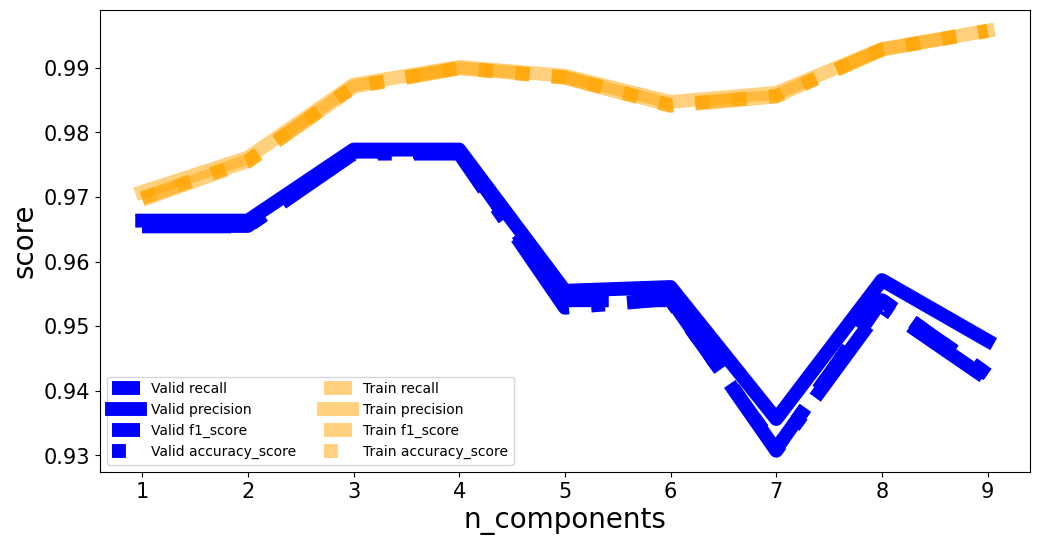

In [163]:
n_components = np.arange(1, 10)
recall_valid = np.zeros(n_components.shape)
precision_valid = np.zeros(n_components.shape)
f1_score_valid = np.zeros(n_components.shape)
accuracy_score_valid = np.zeros(n_components.shape)


recall_train = np.zeros(n_components.shape)
precision_train = np.zeros(n_components.shape)
f1_score_train = np.zeros(n_components.shape)
accuracy_score_train = np.zeros(n_components.shape)

for i, n in enumerate(n_components):
    gmmb = GMMBayes(n_components=n, random_state=0, reg_covar=1e-5)
    gmmb.fit(X_train, y_train)

    # validation set
    y_pred = gmmb.predict(X_valid)
    recall_valid[i] = recall_score(y_valid, y_pred, average='weighted')
    precision_valid[i] = precision_score(y_valid, y_pred, average='weighted')
    f1_score_valid[i] = f1_score(y_valid, y_pred, average='weighted')
    accuracy_score_valid[i] = accuracy_score(y_valid, y_pred)

    # training set
    y_pred_train = gmmb.predict(X_train)
    recall_train[i] = recall_score(y_train, y_pred_train, average='weighted')
    precision_train[i] = precision_score(y_train, y_pred_train, average='weighted')
    f1_score_train[i] = f1_score(y_train, y_pred_train, average='weighted')
    accuracy_score_train[i] = accuracy_score(y_train, y_pred_train)





fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()

# Validation
ax.plot(n_components, recall_valid, label='Valid recall', linewidth=10, color='blue', alpha=1, linestyle='--')
ax.plot(n_components, precision_valid, label='Valid precision', linewidth=10, color='blue', alpha=1)
ax.plot(n_components, f1_score_valid, label='Valid f1_score', linewidth=10, color='blue', alpha=1, linestyle='-.')
ax.plot(n_components, accuracy_score_valid, label='Valid accuracy_score', linewidth=10, color='blue', alpha=1, linestyle=':')

# Training
ax.plot(n_components, recall_train, label='Train recall', linewidth=10, color='orange', alpha=0.5, linestyle='--')
ax.plot(n_components, precision_train, label='Train precision', linewidth=10, color='orange', alpha=0.5)
ax.plot(n_components, f1_score_train, label='Train f1_score', linewidth=10, color='orange', alpha=0.5, linestyle='-.')
ax.plot(n_components, accuracy_score_train, label='Train accuracy_score', linewidth=10, color='orange', alpha=0.5, linestyle=':')

ax.set_xlabel('n_components', fontsize=20)
ax.set_ylabel('score', fontsize=20)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.legend(fontsize=10, ncol=2)
plt.show()

#### The cross validation shows that the preformance is best at 4 componenets before overfitting and a decrease in score. Unlike the previous timeseries dataset validation set preformance ~3% worse that the training set. 